<a href="https://colab.research.google.com/github/paulandrea0/tesis/blob/main/Freq_CrossValidation_en_la_Copia_de_PCA_MLPercepton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
df_VT = pd.read_csv('/gdrive/MyDrive/Sismos/SisDomínio Frequência/fft_1.csv')
df_LP = pd.read_csv('/gdrive/MyDrive/Sismos/SisDomínio Frequência/fft_2.csv')
df_TOR = pd.read_csv('/gdrive/MyDrive/Sismos/SisDomínio Frequência/fft_3.csv')
sismos = pd.read_excel('/gdrive/MyDrive/Sismos/Distribución de datos sísmicos.xlsx')

# Graficando distribución

In [ ]:
sismos.fillna(0, inplace=True)
sismos = sismos.rename(columns={'VTz':'VT seism',
                                   'LPz':'LP seism', 'Tor z':'TOR seism'})

print(sismos.head)
sismos.dtypes

<bound method NDFrame.head of       VT seism     VTn     Vte  LP seism     LPn     LPe  TOR seism    Tor n  \
0         2157  2157.0  2157.0    3000.0  3000.0  3000.0     4672.0   4672.0   
1         2893  2893.0  2893.0    3000.0  3000.0  3000.0     3096.0   3096.0   
2         2207  2207.0  2207.0    3000.0  3000.0  3000.0     7956.0   7956.0   
3         1794  1794.0  1794.0    3000.0  3000.0  3000.0     6507.0   6507.0   
4         1135  1135.0  1135.0    3000.0  3000.0  3000.0    10262.0  10262.0   
...        ...     ...     ...       ...     ...     ...        ...      ...   
1731      2030     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1732      1480     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1733      1347     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1734      1838     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1735      1449     0.0     0.0       0.0     0.0     0.0        0.0      0.0   

        T

VT seism       int64
VTn          float64
Vte          float64
LP seism     float64
LPn          float64
LPe          float64
TOR seism    float64
Tor n        float64
Tor e        float64
dtype: object

In [ ]:
import seaborn as sns

sis = (sismos['VT seism'], sismos['LP seism'], sismos['TOR seism'])
print(sis)

(0       2157
1       2893
2       2207
3       1794
4       1135
        ... 
1731    2030
1732    1480
1733    1347
1734    1838
1735    1449
Name: VT seism, Length: 1736, dtype: int64, 0       3000.0
1       3000.0
2       3000.0
3       3000.0
4       3000.0
         ...  
1731       0.0
1732       0.0
1733       0.0
1734       0.0
1735       0.0
Name: LP seism, Length: 1736, dtype: float64, 0        4672.0
1        3096.0
2        7956.0
3        6507.0
4       10262.0
         ...   
1731        0.0
1732        0.0
1733        0.0
1734        0.0
1735        0.0
Name: TOR seism, Length: 1736, dtype: float64)


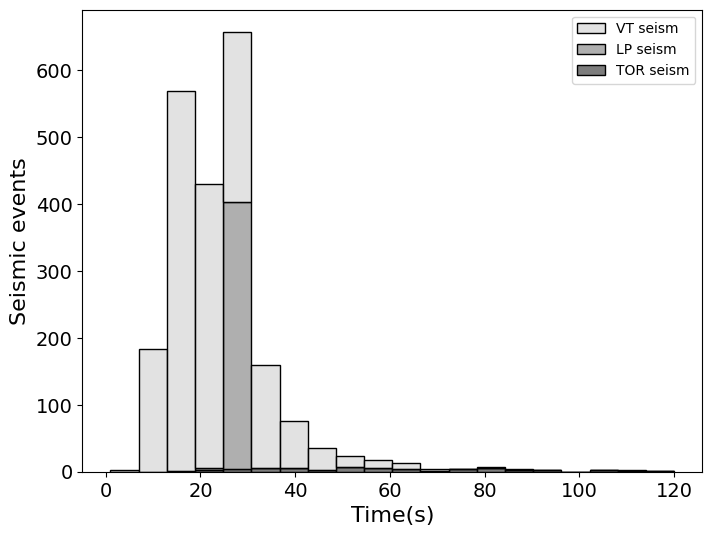

In [ ]:
from seaborn.rcmod import set_palette
import seaborn as sns

sis_segundos = tuple([x/100.0 for x in sis])  # Convertir a segundos

plt.figure(figsize = (8, 6))
axes = plt.gca()
sns.histplot(sis_segundos, binrange=(1,120), bins=20, multiple="stack", palette='Greys', kde=False)     #palette=sns.cubehelix_palette(3, start=1.6)

plt.ylabel('Seismic events')
plt.xlabel('Time(s)')
# plt.title('Distribution of seismic event duration')

axes.title.set_size(20)
axes.xaxis.label.set_size(16)
axes.yaxis.label.set_size(16)
axes.tick_params(axis='both', labelsize=14)
plt.show()
axes.figure.savefig('Histograma.pdf', dpi=400, format='pdf')

# Retirando offset de los datos (serie temporal)

In [ ]:
# Creando función para retirar el offset de los datos en DataFrame
def mean_norma(df_input):
  return df_input.apply(lambda x: (x-x.mean()), axis=1)

df_mean_test_1 = mean_norma(df_test_1) # Señales VT
df_mean_train_1 = mean_norma(df_train_1)
df_mean_test_2 = mean_norma(df_test_2) # Señales LP
df_mean_train_2 = mean_norma(df_train_2)
df_mean_test_3 = mean_norma(df_test_3) # Señales Tor
df_mean_train_3 = mean_norma(df_train_3)

print(df_mean_train_1.shape)
print(df_mean_test_1.shape)
print(df_mean_train_2.shape)
print(df_mean_test_2.shape)
print(df_mean_train_3.shape)
print(df_mean_test_3.shape)

# Convirtiendo el dataframe en array
d_train_1 = df_mean_train_1.values
d_train_1 = d_train_1[:, 0:3000]
d_test_1 = df_mean_test_1.values
d_test_1 = d_test_1[:, 0:3000]

d_train_2 = df_mean_train_2.values
d_train_2 = d_train_2[:, 0:3000]
d_test_2 = df_mean_test_2.values
d_test_2 = d_test_2[:, 0:6000]

d_train_3 = df_mean_train_3.values
d_train_3 = d_train_3[:, 0:3000]
d_test_3 = df_mean_test_3.values
d_test_3 = d_test_3[:, 0:3000]

# Dibujando la señal orioginal
n = 3000
fs = 50 # frecuencia de muestreo
t = np.linspace(0,fs,n)
plt.figure(1, figsize=(30, 4))
plt.subplot(231)
plt.plot(t, d_train_1[60])
plt.subplot(232)
plt.plot(t, d_train_2[18])
plt.subplot(233)
plt.plot(t, d_train_3[38])
plt.subplot(234)
plt.plot(t, d_test_1[44])
plt.subplot(235)
plt.plot(t, d_test_2[34])
plt.subplot(236)
plt.plot(t, d_test_3[4])

NameError: ignored

# Quitando valores NaN de la (serie temporal)

(1480, 3000)
(256, 3000)
(362, 3000)
(40, 3000)
(61, 3000)
(6, 3000)


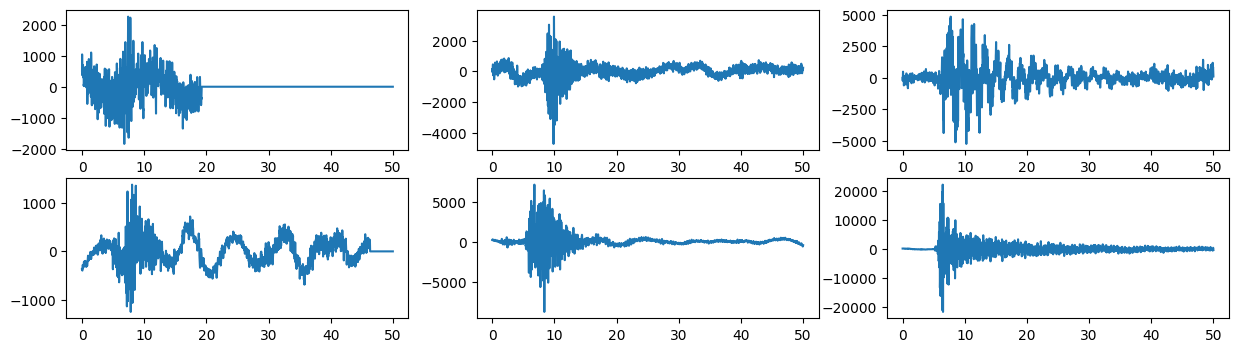

In [ ]:
# Quitando los valores NaN de los array numpy

# Señales VT
d_train_1[np.isnan(d_train_1)] = 0.0
d_test_1[np.isnan(d_test_1)] = 0.0
print(d_train_1.shape)
print(d_test_1.shape)

# Señales LP
d_train_2[np.isnan(d_train_2)] = 0.0
d_test_2[np.isnan(d_test_2)] = 0.0
print(d_train_2.shape)
print(d_test_2.shape)

# Señales Tor`
d_train_3[np.isnan(d_train_3)] = 0.0
d_test_3[np.isnan(d_test_3)] = 0.0
print(d_train_3.shape)
print(d_test_3.shape)

# Graficando
plt.figure(2, figsize=(15, 4))
plt.subplot(231)
plt.plot(t, d_train_1[60])
plt.subplot(232)
plt.plot(t, d_train_2[18])
plt.subplot(233)
plt.plot(t, d_train_3[38])
plt.subplot(234)
plt.plot(t, d_test_1[44])
plt.subplot(235)
plt.plot(t, d_test_2[34])
plt.subplot(236)
plt.plot(t, d_test_3[4])

Calculando espectro de frecuencia

In [ ]:
# Crear una señal senoidal
fs = 100  # Frecuencia de muestreo (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # Vector de tiempo de 1 segundo
transformada = np.fft.fft(señal)

# **P C A**

In [3]:
from sklearn.decomposition import PCA

# Transormando DataFrame a arreglos Numpy
VT = df_VT.values
LP = df_LP.values
Tor = df_TOR.values

pca = PCA(n_components=0.95)
VT_pca = pca.fit_transform(VT)
LP_pca = pca.fit_transform(LP)
Tor_pca = pca.fit_transform(Tor)

Calculando 67 PCA para todos los datos de entrenamiento y prueba (67 que es la
cantidad de ejemplos que se tienen para una de las clases).


In [4]:
pca = PCA(n_components=25)
vt_pc = pca.fit_transform(VT)
lp_pc = pca.fit_transform(LP)
tor_pc = pca.fit_transform(Tor)
print(vt_pc.shape, lp_pc.shape, tor_pc.shape)

(1735, 25) (401, 25) (66, 25)


Aumento un evento (s) por cada clase porque perdí un evento en la transformada de Fourier en cada clase.

In [5]:
s1 = vt_pc[1470, :]
s2 = lp_pc[360, :]
s3 = tor_pc[50, :]

In [6]:
# Concatenar 's1' debajo de 'vt_pc'
vt_pc = np.vstack((s1, vt_pc))
lp_pc = np.vstack((s2, lp_pc))
tor_pc = np.vstack((s3, tor_pc))

Volvemos a separar el set de datos en set de entrenamiento, prueba y validación para su
respectiva normalización.

In [7]:
np.random.shuffle(vt_pc)
total_filas = vt_pc.shape[0]
filas_entrenamiento = int(0.6 * total_filas)
filas_prueba = int(0.2 * total_filas)
train_1 = vt_pc[:filas_entrenamiento]
test_1 = vt_pc[filas_entrenamiento:filas_entrenamiento + filas_prueba]
val_1 = vt_pc[filas_entrenamiento + filas_prueba:]

np.random.shuffle(lp_pc)
total_filas = lp_pc.shape[0]
filas_entrenamiento = int(0.6 * total_filas)
filas_prueba = int(0.2 * total_filas)
train_2 = lp_pc[:filas_entrenamiento]
test_2 = lp_pc[filas_entrenamiento:filas_entrenamiento + filas_prueba]
val_2 = lp_pc[filas_entrenamiento + filas_prueba:]

np.random.shuffle(tor_pc)
total_filas = tor_pc.shape[0]
filas_entrenamiento = int(0.6 * total_filas)
filas_prueba = int(0.2 * total_filas)
train_3 = tor_pc[:filas_entrenamiento]
test_3 = tor_pc[filas_entrenamiento:filas_entrenamiento + filas_prueba]
val_3 = tor_pc[filas_entrenamiento + filas_prueba:]

# **Normalización**

Mínimo y máximo originales: -258601404.7, 891454317.8
Mínimo y máximo normalizado: 0.0, 1.0
Mínimo y máximo originales: -5062597.4, 19624713.5
Mínimo y máximo normalizado: 0.0, 1.0
Mínimo y máximo originales: -40089123.9, 89962944.5
Mínimo y máximo normalizado: 0.0, 1.0


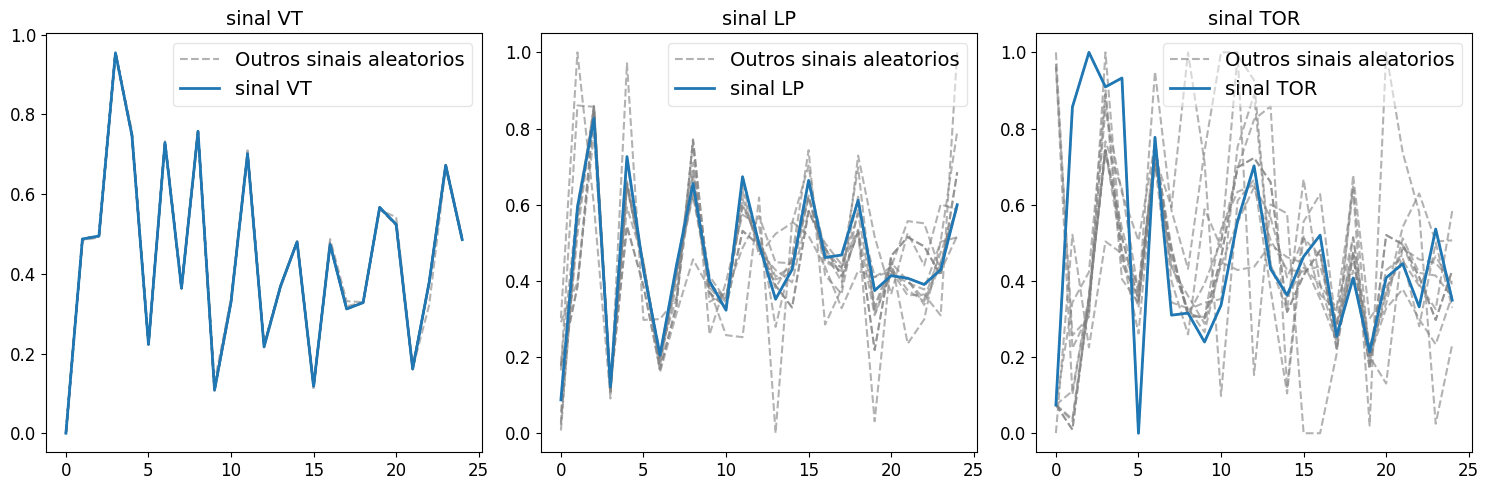

In [8]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

# Señales VT
D_train_s1 = min_max_scaler.fit_transform(train_1)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(train_1), np.max(train_1)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s1), np.max(D_train_s1)))
D_test_s1 = min_max_scaler.transform(test_1)
val_s1 = min_max_scaler.transform(val_1)

# Señales LP
D_train_s2 = min_max_scaler.fit_transform(train_2)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(train_2), np.max(train_2)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s2), np.max(D_train_s2)))
D_test_s2 = min_max_scaler.transform(test_2)
val_s2 = min_max_scaler.transform(val_2)

# Señales Tor
D_train_s3 = min_max_scaler.fit_transform(train_3)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(train_3), np.max(train_3)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s3), np.max(D_train_s3)))
D_test_s3 = min_max_scaler.transform(test_3)
val_s3 = min_max_scaler.transform(val_3)

# Graficando
# Definiendo las clases:
signals_class = [D_train_s1, D_train_s2, D_train_s3]
# Crear una figura de 3x4 subplots
max_signals_per_class = 10
class_names = ['sinal VT', 'sinal LP', 'sinal TOR']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterar sobre las clases y los subplots
for class_idx, signal_class in enumerate(signals_class):
  ax = axs[class_idx]   # Obtener el subplot actual

  # Limitar el número de señales a dibujar por clase
  signal_class = signal_class[:max_signals_per_class]

  # Iterar sobre las señales de la clase y ajustar las propiedades de línea
  for i , signal in enumerate(signal_class):
    # Las señales aleatorias
    ax.plot(signal, linestyle='--', alpha=0.6, label=None, color="grey")

  # primera señal con línea sólida y grosor 2
  ax.plot(signal, linestyle='--', alpha=0.6, label="Outros sinais aleatorios", color="grey")
  ax.plot(signal_class[0], lw=2, label=(class_names[class_idx]), color="tab:blue")

  # Añadir leyenda y etiquetas
  ax.legend(fontsize='14', fancybox=True, framealpha=0.5)
  ax.tick_params(axis='both', labelsize=12)
  ax.set_title(class_names[class_idx], fontsize=14)

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Guardar el gráfico en formato PDF con resolución de 300 DPI
plt.savefig("grafico.pdf", dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

# **Clasificación con MLPerceptron**

Preparando los datos para ser presentados en el clasificador

In [9]:
# a continuación son adicionadas tres columnas que me permitirán ser usadas
D_train_s1 = np.insert(D_train_s1, [0], (0), axis=1)
D_test_s1 = np.insert(D_test_s1, [0], (0), axis=1)
D_train_s2 = np.insert(D_train_s2, [0], (1), axis=1)
D_test_s2 = np.insert(D_test_s2, [0], (1), axis=1)
D_train_s3 = np.insert(D_train_s3, [0], (2), axis=1)
D_test_s3 = np.insert(D_test_s3, [0], (2), axis=1)

print(D_train_s1[1,0:5], D_test_s1[1,0:5])
print(D_train_s2[1,0:5], D_test_s2[1,0:5])
print(D_train_s3[1,0:5], D_test_s3[1,0:5])
print(D_train_s1[1,0:5], D_test_s1[1,0:5])
print(D_train_s2[1,0:5], D_test_s2[1,0:5])
print(D_train_s3[1,0:5], D_test_s3[1,0:5])

# Creo mi set de entrenamiento con sismos y sus etiquetas correspondientes y
set_train = np.concatenate([D_train_s1,D_train_s2, D_train_s3], axis=0)   # hasta aquí las clases están en orden
set_test = np.concatenate([D_test_s1,D_test_s2, D_test_s3], axis=0)    # hasta aquí las clases están en orden
dataset = np.concatenate([set_train, set_test])     # hasta aquí las clases están en orden

# le doy una mezcla a los datos para que entren en desorden en la red neuron
np.random.shuffle(dataset)

print(set_train.shape, set_test.shape)
print(dataset.shape)

[0.00000000e+00 1.26643559e-04 4.87318573e-01 4.94740864e-01
 9.54383356e-01] [0.00000000e+00 2.52094446e-04 4.87102276e-01 4.94635739e-01
 9.54307452e-01]
[1.         0.02231235 0.55635916 0.8559455  0.10493392] [1.         0.05457112 0.5308139  0.82627941 0.12486394]
[2.         0.9613779  0.25674996 0.30531423 1.        ] [2.         0.07434489 0.29097435 0.39708924 0.94324045]
[0.00000000e+00 1.26643559e-04 4.87318573e-01 4.94740864e-01
 9.54383356e-01] [0.00000000e+00 2.52094446e-04 4.87102276e-01 4.94635739e-01
 9.54307452e-01]
[1.         0.02231235 0.55635916 0.8559455  0.10493392] [1.         0.05457112 0.5308139  0.82627941 0.12486394]
[2.         0.9613779  0.25674996 0.30531423 1.        ] [2.         0.07434489 0.29097435 0.39708924 0.94324045]
(1322, 26) (440, 26)
(1762, 26)


In [10]:
print(dataset.shape)
X = np.delete(dataset, 0, axis=1)
y = dataset[: , 0]
print(X.shape, y.shape)

(1762, 26)
(1762, 25) (1762,)


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import Sequential
from keras.regularizers import l2 # cuando hay sobreajuste la regularización
# a decartar valores altos en la función de costo. Se puede colocar en cualq
from keras.layers import Dropout #apagar aleatoriamente algunas neuronas,
# ayudando a eliminar el sobreajuste
from keras.callbacks import EarlyStopping
from keras.activations import relu, sigmoid, tanh
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Código CrossVal Stratifyed by Reginaldo

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.7139 - auc: 0.9364
Epoch 2/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3358 - auc: 0.9718
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1919 - auc: 0.9862
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1395 - auc: 0.9951
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1132 - auc: 0.9976
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0956 - auc: 0.9980
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0826 - auc: 0.9983
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0740 - auc: 0.9983
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0657 - auc: 0.9985
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0596 - auc: 0.9985
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

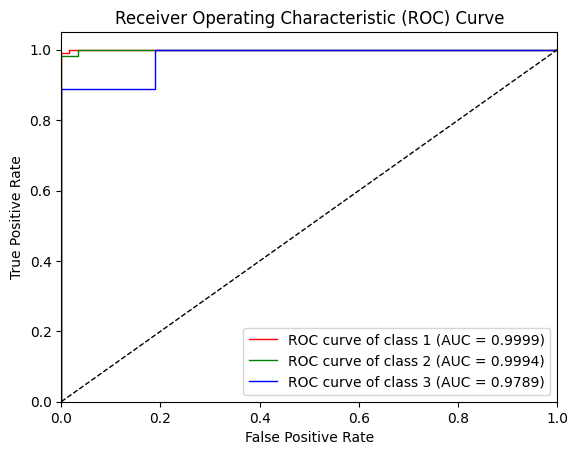

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 1.0556 - auc: 0.8900
Epoch 2/25
92/92 [==============================] - 0s 2ms/step - loss: 0.9240 - auc: 0.9704
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.6070 - auc: 0.9814
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.2249 - auc: 0.9925
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1039 - auc: 0.9987
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0719 - auc: 0.9987
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0565 - auc: 0.9991
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0459 - auc: 0.9992
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0378 - auc: 0.9994
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0337 - auc: 0.9995
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

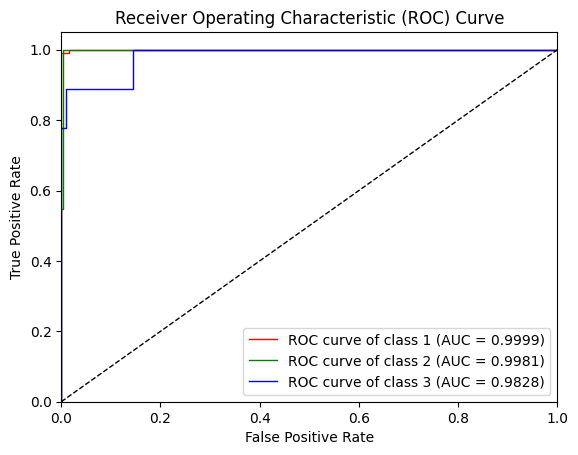

Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 0.9339 - auc: 0.8517
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5983 - auc: 0.9327
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3685 - auc: 0.9726
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.1629 - auc: 0.9962
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0887 - auc: 0.9982
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0650 - auc: 0.9988
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0518 - auc: 0.9992
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0446 - auc: 0.9994
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0384 - auc: 0.9992
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0356 - auc: 0.9992
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

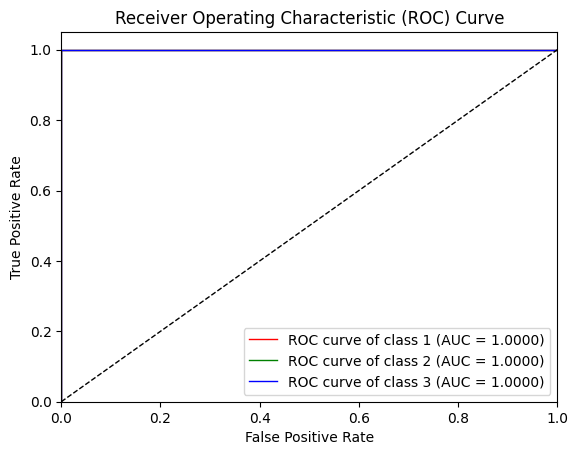

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.7926 - auc: 0.8360
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3976 - auc: 0.9684
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1852 - auc: 0.9919
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1165 - auc: 0.9982
Epoch 5/25
92/92 [==============================] - 1s 6ms/step - loss: 0.0882 - auc: 0.9988
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0721 - auc: 0.9991
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0611 - auc: 0.9993
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0526 - auc: 0.9995
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0468 - auc: 0.9996
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0407 - auc: 0.9997
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

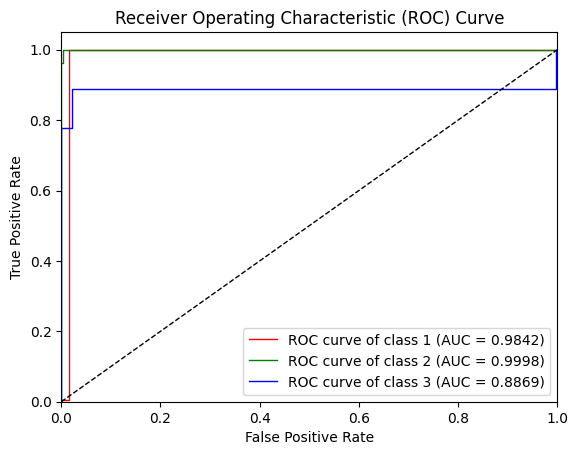

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7144 - auc: 0.8780
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4053 - auc: 0.9665
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.2166 - auc: 0.9907
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1267 - auc: 0.9972
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1046 - auc: 0.9982
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0950 - auc: 0.9985
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0897 - auc: 0.9984
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0857 - auc: 0.9986
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0810 - auc: 0.9987
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0766 - auc: 0.9988
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

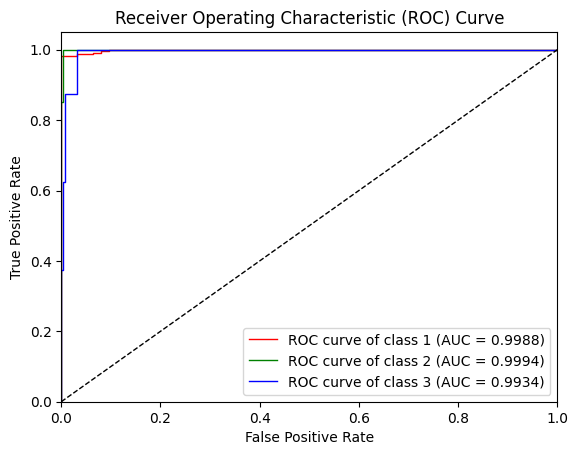

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.6360 - auc: 0.9111
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3872 - auc: 0.9680
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2043 - auc: 0.9894
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.1401 - auc: 0.9942
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1131 - auc: 0.9972
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0952 - auc: 0.9978
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0806 - auc: 0.9982
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0685 - auc: 0.9984
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0588 - auc: 0.9986
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0508 - auc: 0.9988
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

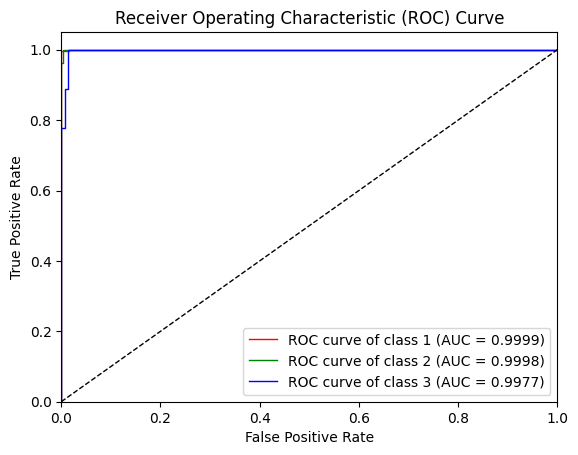

#########################################
Units: 20 Activation Function: relu AUC Média: 0.989946148736974
#########################################
Epoch 1/25
92/92 [==============================] - 2s 3ms/step - loss: 0.6862 - auc: 0.8806
Epoch 2/25
92/92 [==============================] - 1s 12ms/step - loss: 0.5987 - auc: 0.9491
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5734 - auc: 0.9592
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5431 - auc: 0.9606
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4955 - auc: 0.9620
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4232 - auc: 0.9615
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3341 - auc: 0.9756
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2538 - auc: 0.9825
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.1989 - auc: 0.9933
Epoch 10/25
9

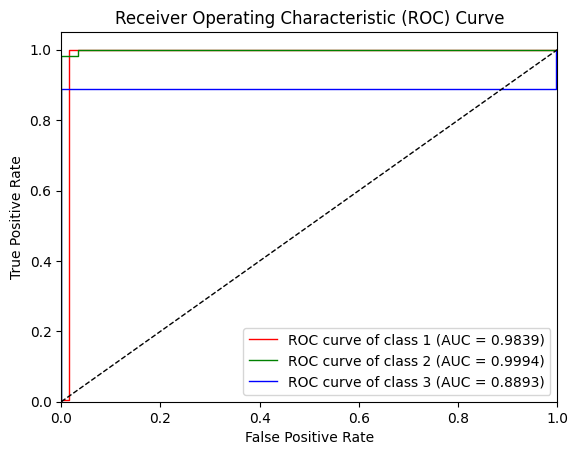

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.6633 - auc: 0.8776
Epoch 2/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5926 - auc: 0.9531
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5537 - auc: 0.9616
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5001 - auc: 0.9620
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4174 - auc: 0.9618
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3191 - auc: 0.9735
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2368 - auc: 0.9902
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1850 - auc: 0.9928
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1554 - auc: 0.9934
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1380 - auc: 0.9952
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

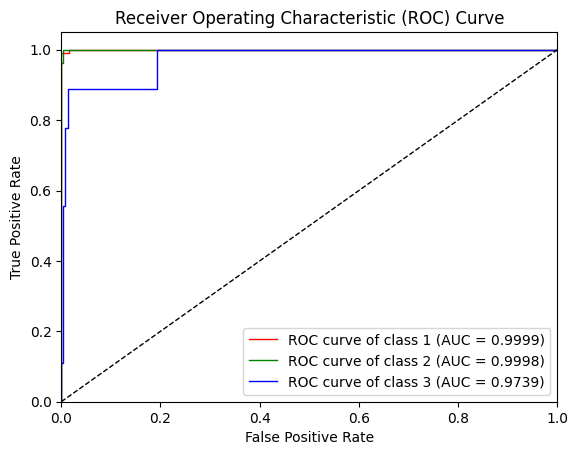

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.8376 - auc: 0.8363
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6409 - auc: 0.8696
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6069 - auc: 0.9245
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5812 - auc: 0.9577
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5465 - auc: 0.9609
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4918 - auc: 0.9611
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4110 - auc: 0.9616
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3197 - auc: 0.9759
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2411 - auc: 0.9892
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1906 - auc: 0.9912
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

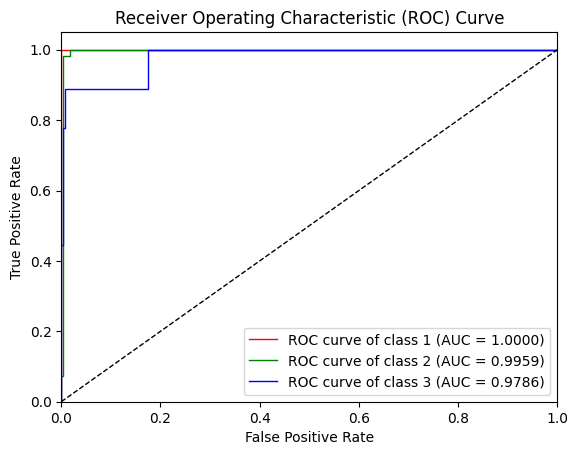

Epoch 1/25
92/92 [==============================] - 3s 8ms/step - loss: 0.6800 - auc: 0.8422
Epoch 2/25
92/92 [==============================] - 1s 8ms/step - loss: 0.5972 - auc: 0.9380
Epoch 3/25
92/92 [==============================] - 1s 9ms/step - loss: 0.5600 - auc: 0.9596
Epoch 4/25
92/92 [==============================] - 1s 6ms/step - loss: 0.5117 - auc: 0.9616
Epoch 5/25
92/92 [==============================] - 1s 7ms/step - loss: 0.4407 - auc: 0.9625
Epoch 6/25
92/92 [==============================] - 1s 6ms/step - loss: 0.3553 - auc: 0.9634
Epoch 7/25
92/92 [==============================] - 1s 6ms/step - loss: 0.2751 - auc: 0.9844
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2154 - auc: 0.9921
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.1766 - auc: 0.9938
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.1536 - auc: 0.9945
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

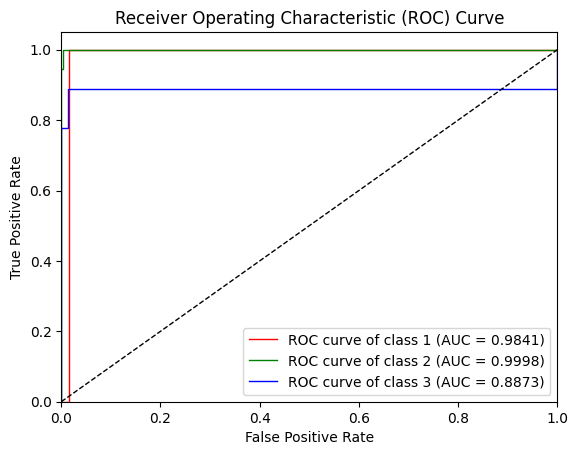

Epoch 1/25
92/92 [==============================] - 3s 4ms/step - loss: 0.8447 - auc: 0.7979
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6454 - auc: 0.8968
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6117 - auc: 0.9371
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5940 - auc: 0.9366
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5731 - auc: 0.9608
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5395 - auc: 0.9613
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4878 - auc: 0.9614
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4164 - auc: 0.9613
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3387 - auc: 0.9682
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2705 - auc: 0.9898
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

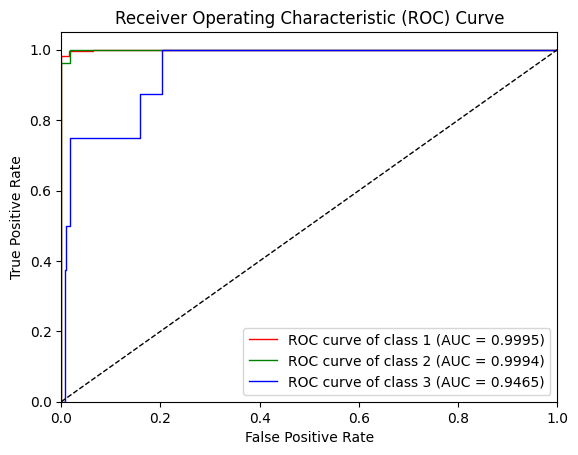

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 1.0168 - auc: 0.6734
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6536 - auc: 0.8996
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5991 - auc: 0.9495
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5714 - auc: 0.9562
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5392 - auc: 0.9581
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4916 - auc: 0.9601
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4273 - auc: 0.9623
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3511 - auc: 0.9697
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.2777 - auc: 0.9814
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2216 - auc: 0.9876
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

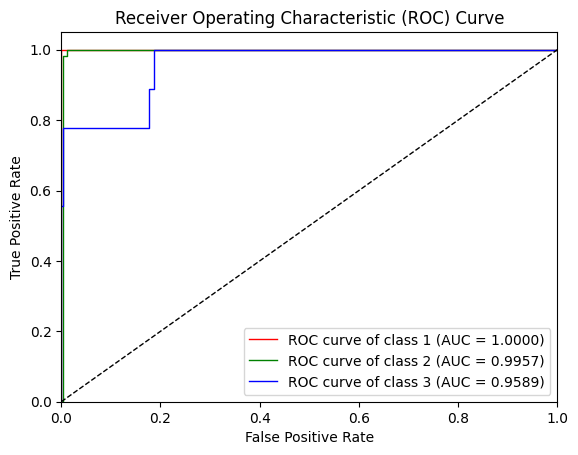

#########################################
Units: 20 Activation Function: sigmoid AUC Média: 0.9773249037005399
#########################################
Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 0.7016 - auc: 0.8731
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4502 - auc: 0.9625
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2312 - auc: 0.9926
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1290 - auc: 0.9973
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0982 - auc: 0.9980
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0803 - auc: 0.9983
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0677 - auc: 0.9985
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0550 - auc: 0.9988
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0484 - auc: 0.9994
Epoch 10/2

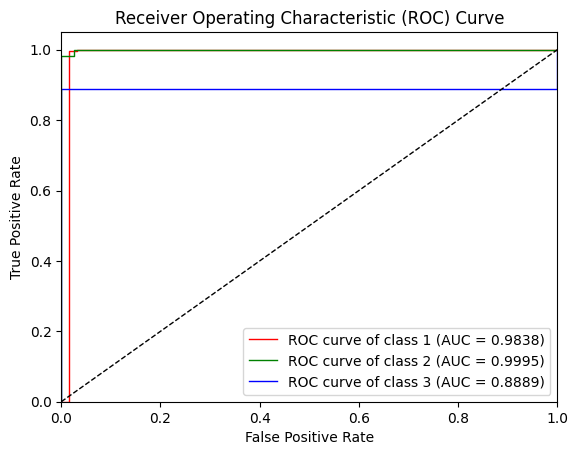

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.4512 - auc: 0.9588
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1838 - auc: 0.9932
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1191 - auc: 0.9961
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0956 - auc: 0.9965
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0815 - auc: 0.9967
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0689 - auc: 0.9974
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0603 - auc: 0.9978
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0525 - auc: 0.9977
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0464 - auc: 0.9982
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0413 - auc: 0.9983
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

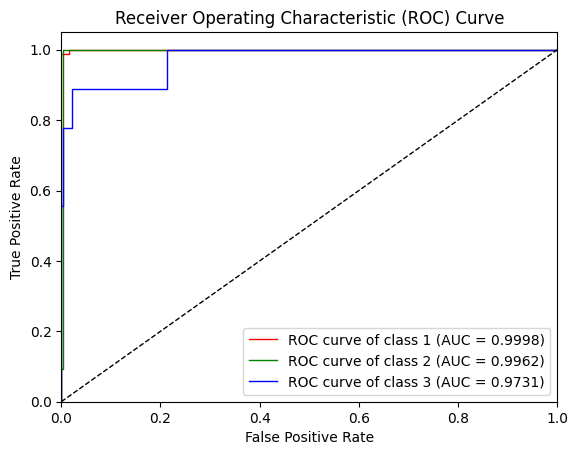

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7294 - auc: 0.9025
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3725 - auc: 0.9741
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.1828 - auc: 0.9942
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1127 - auc: 0.9980
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0796 - auc: 0.9981
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0621 - auc: 0.9986
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0522 - auc: 0.9987
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0450 - auc: 0.9989
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0403 - auc: 0.9991
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0356 - auc: 0.9992
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

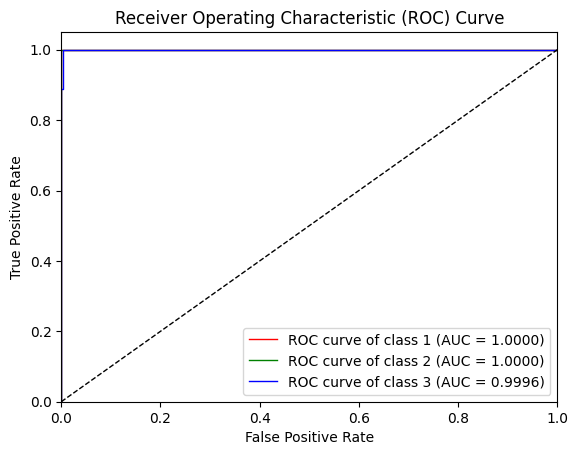

Epoch 1/25
92/92 [==============================] - 2s 3ms/step - loss: 0.6652 - auc: 0.9107
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3393 - auc: 0.9730
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1836 - auc: 0.9934
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1333 - auc: 0.9964
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1078 - auc: 0.9977
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0893 - auc: 0.9980
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0736 - auc: 0.9984
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0628 - auc: 0.9987
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0541 - auc: 0.9989
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0458 - auc: 0.9992
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

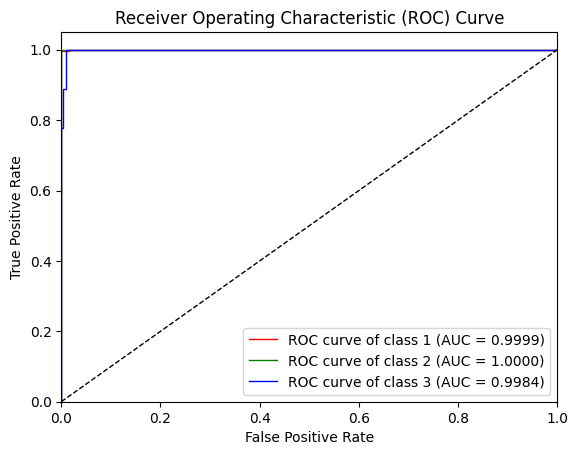

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.7032 - auc: 0.8839
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3693 - auc: 0.9709
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1988 - auc: 0.9912
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1296 - auc: 0.9971
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1014 - auc: 0.9981
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0829 - auc: 0.9983
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0678 - auc: 0.9987
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0559 - auc: 0.9990
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0464 - auc: 0.9993
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0405 - auc: 0.9995
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

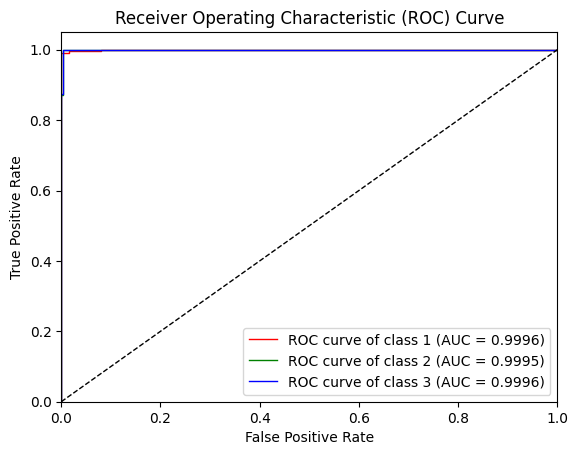

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.6249 - auc: 0.9105
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3573 - auc: 0.9733
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1807 - auc: 0.9946
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1216 - auc: 0.9969
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1023 - auc: 0.9973
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0886 - auc: 0.9978
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0756 - auc: 0.9983
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0641 - auc: 0.9986
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0550 - auc: 0.9987
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0463 - auc: 0.9993
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

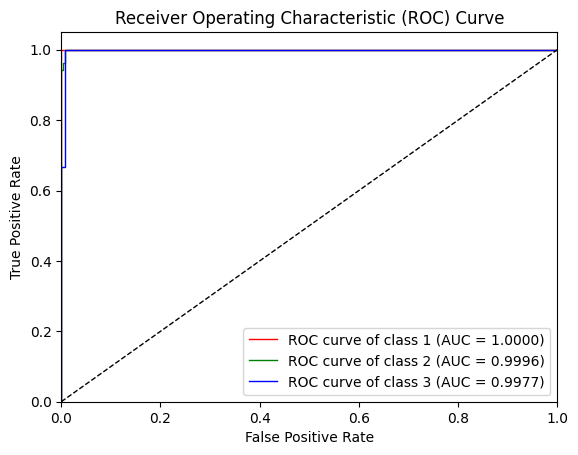

#########################################
Units: 20 Activation Function: tanh AUC Média: 0.9908441705477552
#########################################
Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.8971 - auc: 0.8370
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4793 - auc: 0.9655
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2612 - auc: 0.9816
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1618 - auc: 0.9918
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1236 - auc: 0.9969
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1057 - auc: 0.9980
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0964 - auc: 0.9980
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0886 - auc: 0.9984
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0832 - auc: 0.9987
Epoch 10/25
9

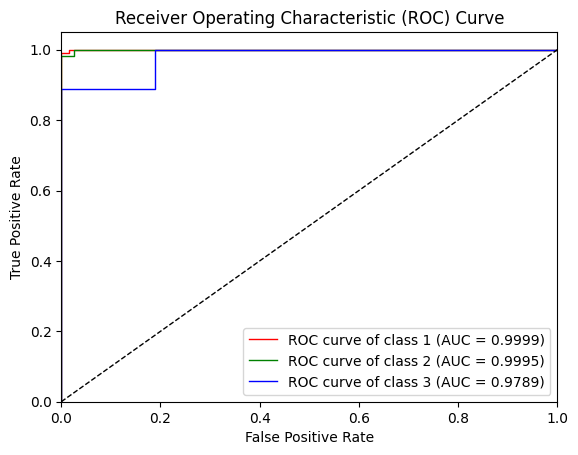

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.6527 - auc: 0.8824
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5158 - auc: 0.9654
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3909 - auc: 0.9706
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2442 - auc: 0.9911
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1467 - auc: 0.9947
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.1056 - auc: 0.9966
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0861 - auc: 0.9974
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0716 - auc: 0.9982
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0573 - auc: 0.9982
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0470 - auc: 0.9989
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

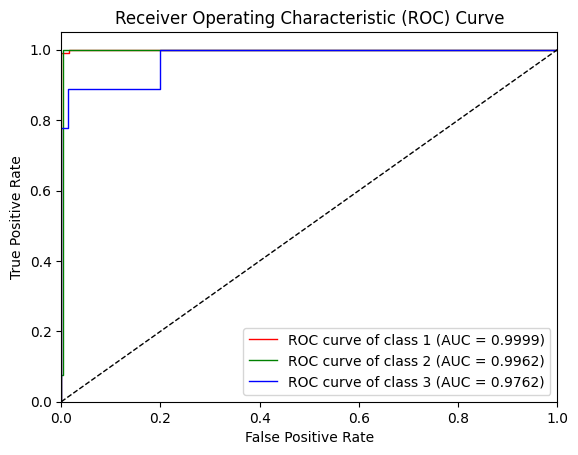

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.7960 - auc: 0.8383
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4479 - auc: 0.9612
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.2579 - auc: 0.9862
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1453 - auc: 0.9954
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1063 - auc: 0.9970
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0855 - auc: 0.9978
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0733 - auc: 0.9980
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0641 - auc: 0.9984
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0567 - auc: 0.9986
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0502 - auc: 0.9990
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

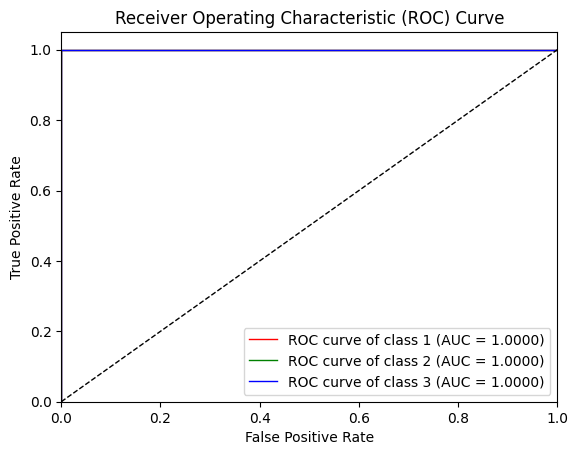

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7771 - auc: 0.8675
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5018 - auc: 0.9570
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3359 - auc: 0.9711
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2308 - auc: 0.9926
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1811 - auc: 0.9939
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1504 - auc: 0.9949
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1289 - auc: 0.9953
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1136 - auc: 0.9965
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1008 - auc: 0.9975
Epoch 10/25
92/92 [==============================] - 1s 8ms/step - loss: 0.0901 - auc: 0.9982
Epoch 11/25
92/92 [==============================] - 1s 14ms/step - l

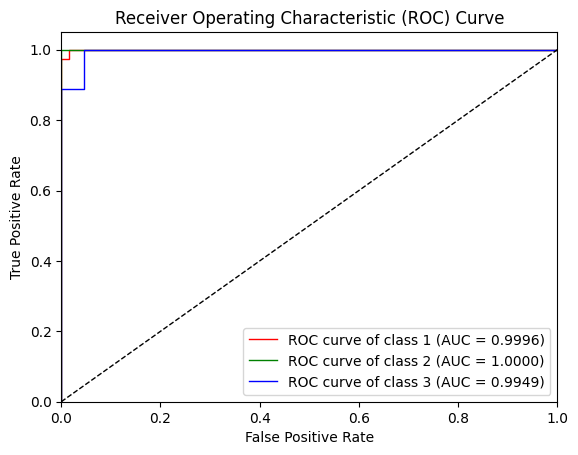

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 1.0022 - auc: 0.7885
Epoch 2/25
92/92 [==============================] - 0s 2ms/step - loss: 0.6473 - auc: 0.9686
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3181 - auc: 0.9755
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1876 - auc: 0.9881
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1419 - auc: 0.9951
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1171 - auc: 0.9968
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1002 - auc: 0.9973
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0885 - auc: 0.9978
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0794 - auc: 0.9978
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0722 - auc: 0.9981
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

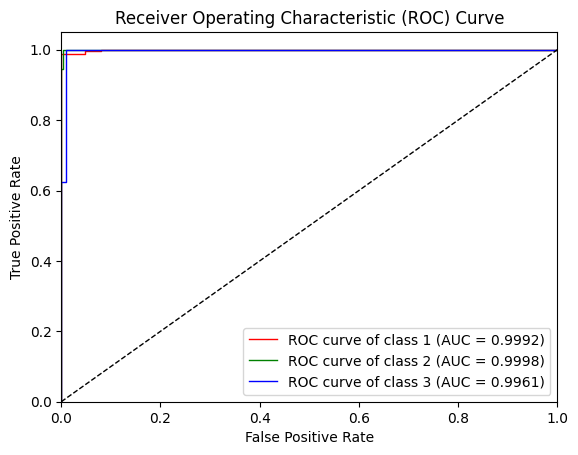

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7008 - auc: 0.9191
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4003 - auc: 0.9682
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2177 - auc: 0.9920
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1313 - auc: 0.9970
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0997 - auc: 0.9978
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0811 - auc: 0.9984
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0687 - auc: 0.9990
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0579 - auc: 0.9993
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0500 - auc: 0.9995
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0438 - auc: 0.9995
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

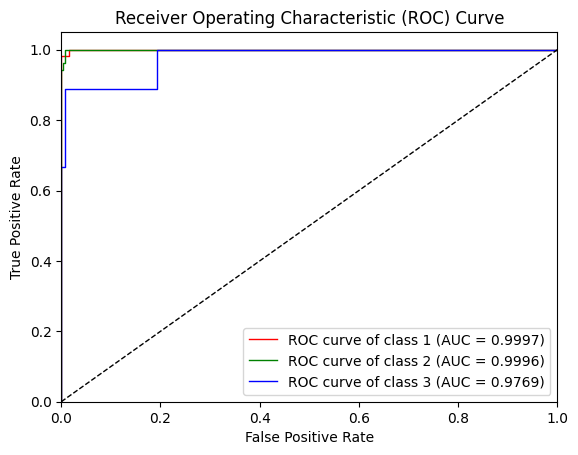

#########################################
Units: 18 Activation Function: relu AUC Média: 0.9953554418365581
#########################################
Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 1.0425 - auc: 0.6441
Epoch 2/25
92/92 [==============================] - 0s 2ms/step - loss: 0.6661 - auc: 0.8835
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.6155 - auc: 0.8956
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6000 - auc: 0.9398
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5863 - auc: 0.9591
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5669 - auc: 0.9610
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5380 - auc: 0.9617
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4922 - auc: 0.9619
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4264 - auc: 0.9624
Epoch 10/25
9

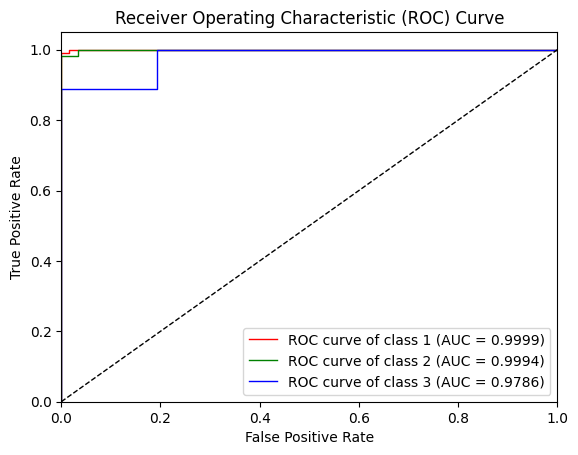

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.9768 - auc: 0.6620
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6691 - auc: 0.8701
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6152 - auc: 0.8815
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6021 - auc: 0.9248
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5918 - auc: 0.9510
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5752 - auc: 0.9599
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5456 - auc: 0.9607
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4986 - auc: 0.9621
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4317 - auc: 0.9622
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3513 - auc: 0.9679
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

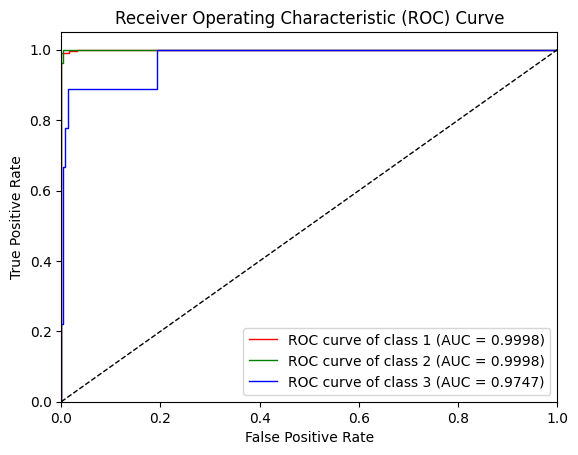

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.7984 - auc: 0.8426
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6339 - auc: 0.9330
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5903 - auc: 0.9574
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5547 - auc: 0.9598
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5066 - auc: 0.9612
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4388 - auc: 0.9620
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3591 - auc: 0.9623
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2838 - auc: 0.9832
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2273 - auc: 0.9911
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1903 - auc: 0.9922
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

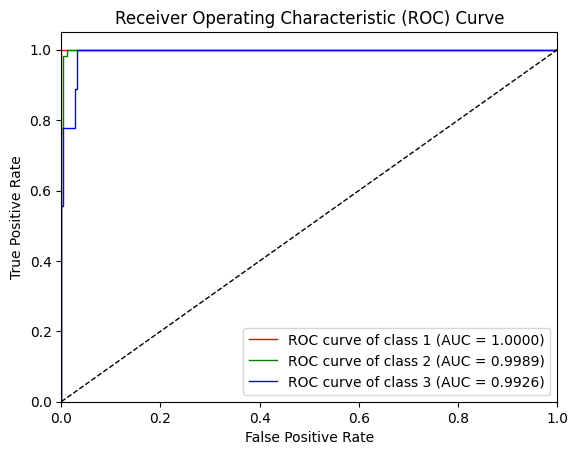

Epoch 1/25
92/92 [==============================] - 2s 3ms/step - loss: 0.7802 - auc: 0.8614
Epoch 2/25
92/92 [==============================] - 0s 2ms/step - loss: 0.6331 - auc: 0.9018
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.6006 - auc: 0.9454
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5758 - auc: 0.9510
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5433 - auc: 0.9613
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4950 - auc: 0.9620
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4257 - auc: 0.9628
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3436 - auc: 0.9709
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2679 - auc: 0.9813
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2132 - auc: 0.9897
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

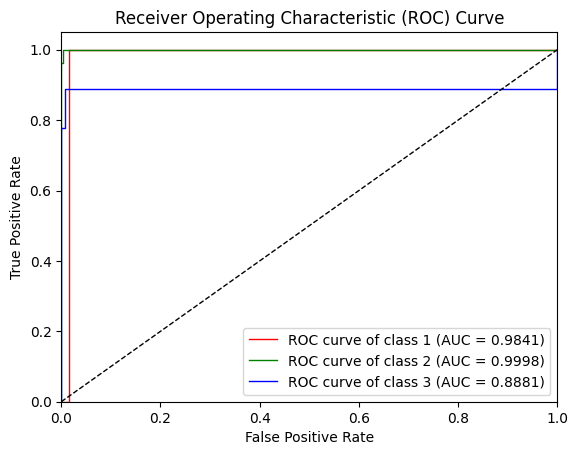

Epoch 1/25
92/92 [==============================] - 2s 3ms/step - loss: 0.7650 - auc: 0.8654
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6214 - auc: 0.8919
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5991 - auc: 0.9474
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5824 - auc: 0.9584
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5577 - auc: 0.9610
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5199 - auc: 0.9607
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4597 - auc: 0.9619
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3786 - auc: 0.9627
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2974 - auc: 0.9793
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2354 - auc: 0.9888
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

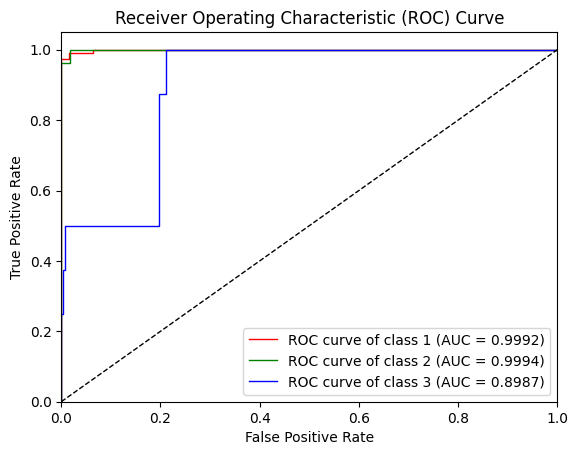

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.7712 - auc: 0.8479
Epoch 2/25
92/92 [==============================] - 0s 2ms/step - loss: 0.6093 - auc: 0.8947
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5906 - auc: 0.9526
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5737 - auc: 0.9597
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5486 - auc: 0.9606
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5095 - auc: 0.9611
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4499 - auc: 0.9618
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3753 - auc: 0.9624
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2987 - auc: 0.9795
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2370 - auc: 0.9866
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

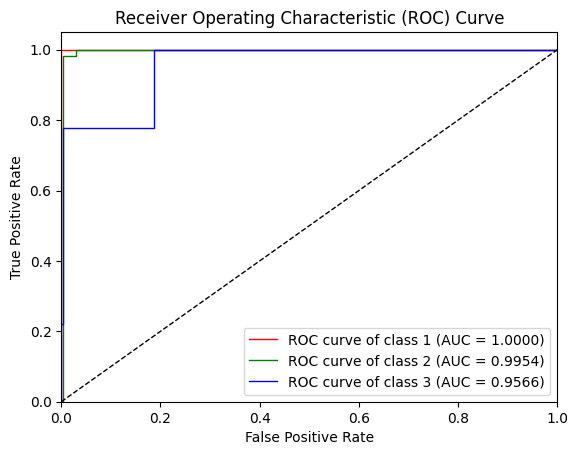

#########################################
Units: 18 Activation Function: sigmoid AUC Média: 0.9813800506755221
#########################################
Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.4611 - auc: 0.9593
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2213 - auc: 0.9880
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1348 - auc: 0.9968
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1032 - auc: 0.9980
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0838 - auc: 0.9984
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0702 - auc: 0.9987
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0577 - auc: 0.9991
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0488 - auc: 0.9993
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0417 - auc: 0.9994
Epoch 10/2

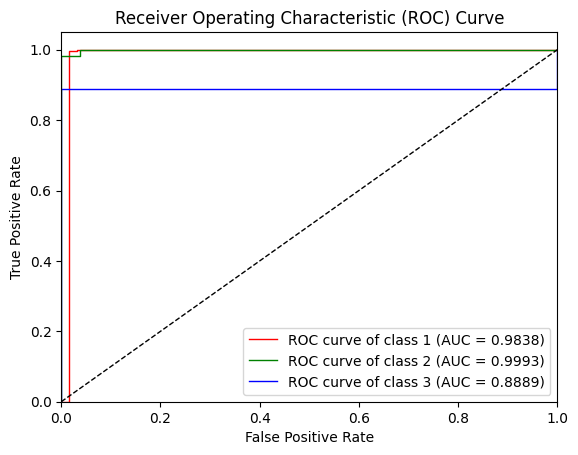

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.5613 - auc: 0.9301
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3212 - auc: 0.9786
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1608 - auc: 0.9958
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1123 - auc: 0.9974
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0916 - auc: 0.9985
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0766 - auc: 0.9988
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0650 - auc: 0.9992
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0532 - auc: 0.9992
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0455 - auc: 0.9996
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0393 - auc: 0.9997
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

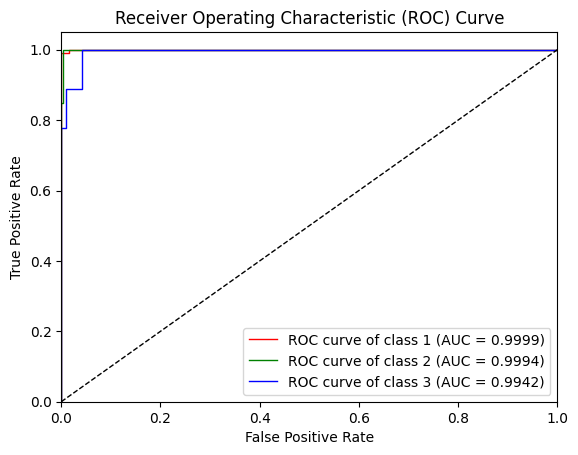

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.6723 - auc: 0.8967
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3897 - auc: 0.9657
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2265 - auc: 0.9897
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1418 - auc: 0.9962
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1096 - auc: 0.9966
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0919 - auc: 0.9973
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0772 - auc: 0.9977
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0657 - auc: 0.9982
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0565 - auc: 0.9986
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0495 - auc: 0.9989
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

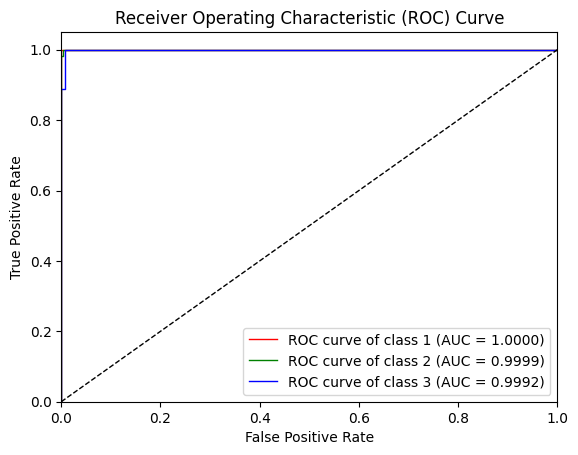

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.6895 - auc: 0.8564
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4218 - auc: 0.9623
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2149 - auc: 0.9898
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1422 - auc: 0.9947
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1187 - auc: 0.9972
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1066 - auc: 0.9979
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0980 - auc: 0.9981
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0909 - auc: 0.9984
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0841 - auc: 0.9985
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0753 - auc: 0.9986
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

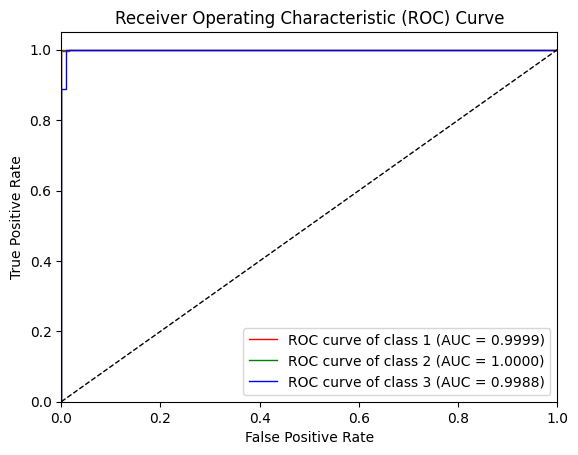

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.6799 - auc: 0.9129
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3479 - auc: 0.9772
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1739 - auc: 0.9951
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1190 - auc: 0.9976
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0947 - auc: 0.9980
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0801 - auc: 0.9983
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0662 - auc: 0.9986
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0572 - auc: 0.9988
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0492 - auc: 0.9991
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0430 - auc: 0.9992
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

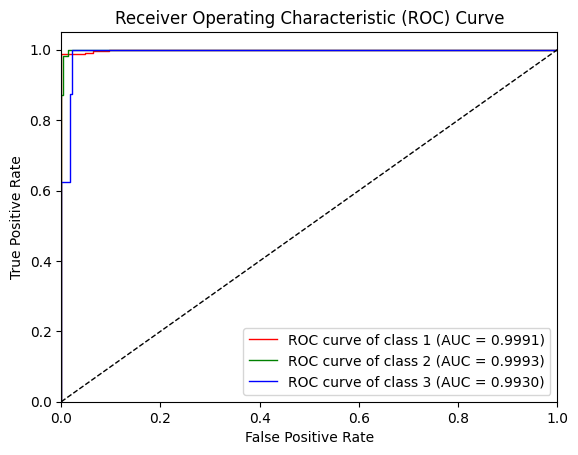

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.5024 - auc: 0.9509
Epoch 2/25
92/92 [==============================] - 0s 2ms/step - loss: 0.2424 - auc: 0.9898
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1343 - auc: 0.9969
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1022 - auc: 0.9977
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0829 - auc: 0.9981
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0677 - auc: 0.9985
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0563 - auc: 0.9992
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0466 - auc: 0.9994
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0400 - auc: 0.9995
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0362 - auc: 0.9995
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

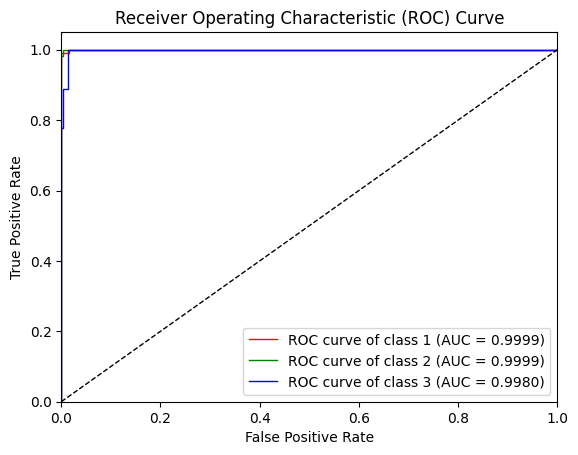

#########################################
Units: 18 Activation Function: tanh AUC Média: 0.9918044545415136
#########################################
Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.8668 - auc: 0.8429
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3767 - auc: 0.9693
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.2013 - auc: 0.9874
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1353 - auc: 0.9960
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1028 - auc: 0.9978
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0840 - auc: 0.9983
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0718 - auc: 0.9985
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0626 - auc: 0.9986
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0567 - auc: 0.9988
Epoch 10/25
9

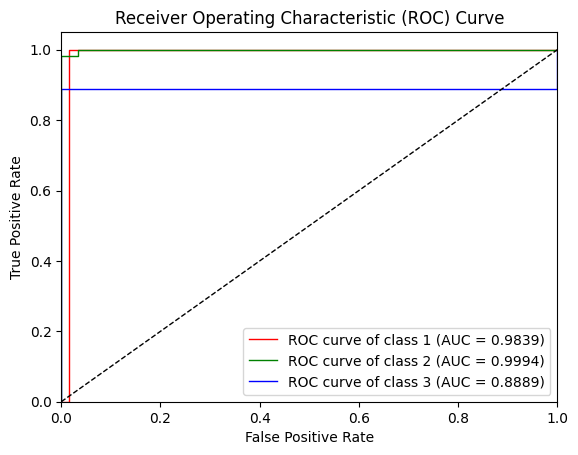

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.6893 - auc: 0.8735
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4979 - auc: 0.9683
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3037 - auc: 0.9840
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1578 - auc: 0.9950
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1067 - auc: 0.9973
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0904 - auc: 0.9976
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0790 - auc: 0.9981
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0692 - auc: 0.9983
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0619 - auc: 0.9984
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0560 - auc: 0.9986
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

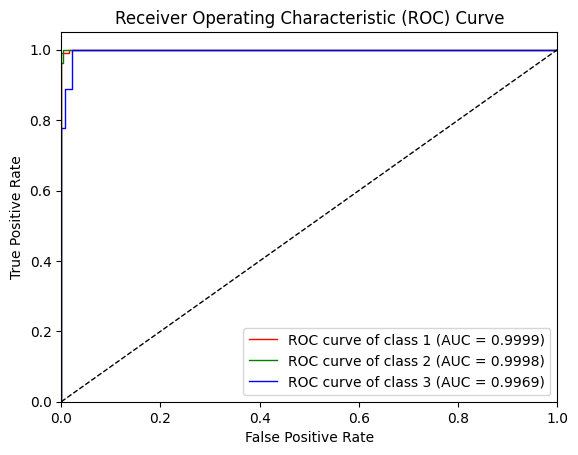

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 1.0288 - auc: 0.6448
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6387 - auc: 0.9041
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3403 - auc: 0.9818
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1887 - auc: 0.9951
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1285 - auc: 0.9961
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1100 - auc: 0.9963
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1026 - auc: 0.9966
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0982 - auc: 0.9970
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0954 - auc: 0.9973
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0911 - auc: 0.9976
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

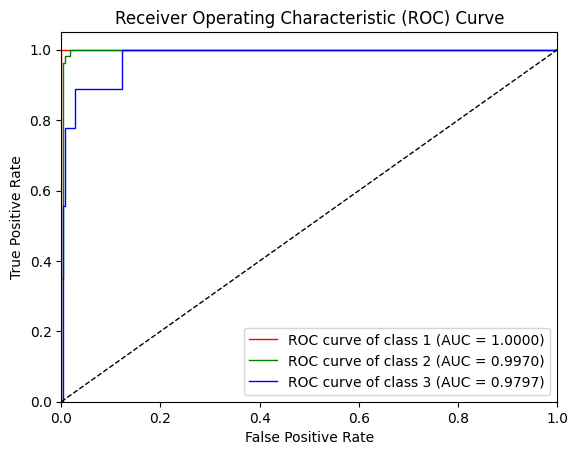

Epoch 1/25
92/92 [==============================] - 1s 2ms/step - loss: 0.9179 - auc: 0.8305
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6283 - auc: 0.8914
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5151 - auc: 0.9608
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3731 - auc: 0.9698
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.2337 - auc: 0.9897
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1403 - auc: 0.9956
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1075 - auc: 0.9976
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0875 - auc: 0.9984
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0729 - auc: 0.9989
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0612 - auc: 0.9992
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

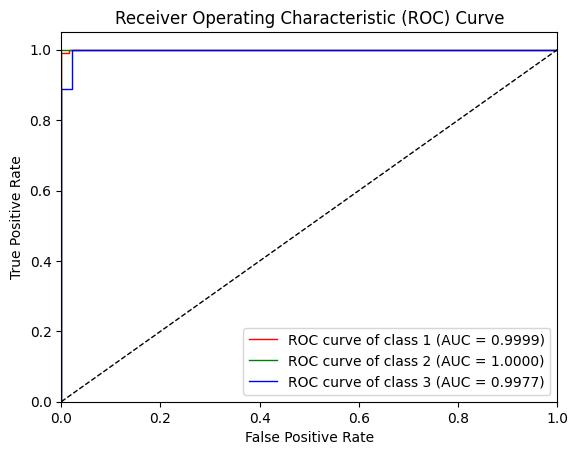

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 1.0062 - auc: 0.7422
Epoch 2/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5906 - auc: 0.9740
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3176 - auc: 0.9792
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1972 - auc: 0.9853
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1392 - auc: 0.9957
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1125 - auc: 0.9975
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0978 - auc: 0.9977
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0872 - auc: 0.9978
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0783 - auc: 0.9981
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0703 - auc: 0.9983
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

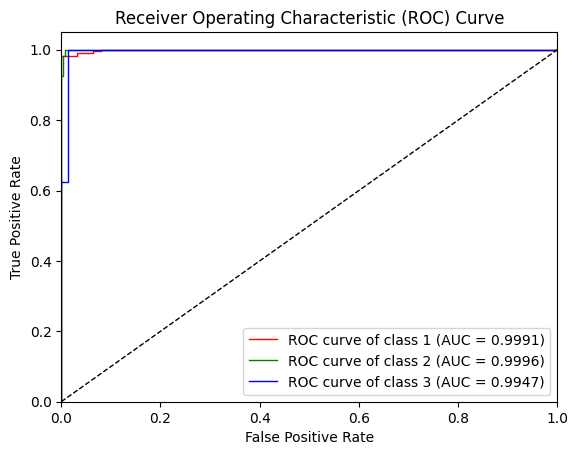

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7444 - auc: 0.9500
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3234 - auc: 0.9758
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1959 - auc: 0.9873
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1372 - auc: 0.9954
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1100 - auc: 0.9971
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0957 - auc: 0.9976
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0830 - auc: 0.9980
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0745 - auc: 0.9979
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0659 - auc: 0.9981
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0602 - auc: 0.9981
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

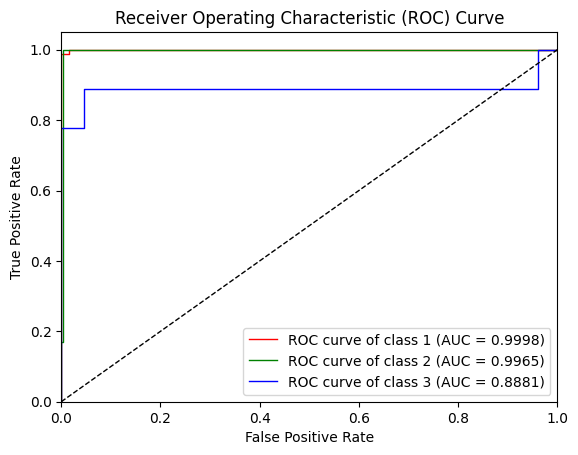

#########################################
Units: 16 Activation Function: relu AUC Média: 0.9844910994148534
#########################################
Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7051 - auc: 0.8735
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6065 - auc: 0.8916
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5925 - auc: 0.9283
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5753 - auc: 0.9590
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5492 - auc: 0.9624
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5091 - auc: 0.9623
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4485 - auc: 0.9624
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3734 - auc: 0.9624
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3015 - auc: 0.9813
Epoch 10/25
9

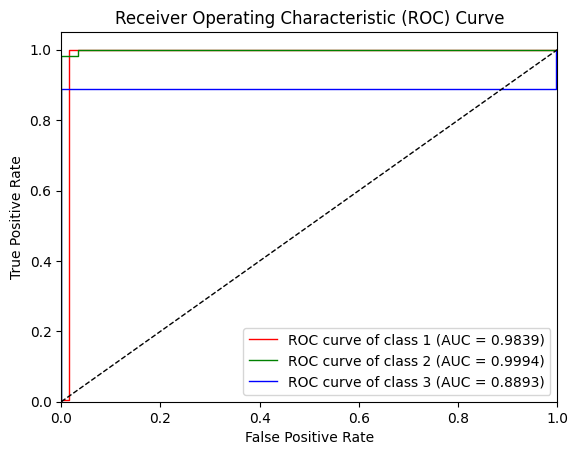

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.8307 - auc: 0.8111
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6426 - auc: 0.8873
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.6099 - auc: 0.9310
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5921 - auc: 0.9581
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5742 - auc: 0.9615
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5486 - auc: 0.9618
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5126 - auc: 0.9618
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4606 - auc: 0.9619
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3917 - auc: 0.9620
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3163 - auc: 0.9784
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

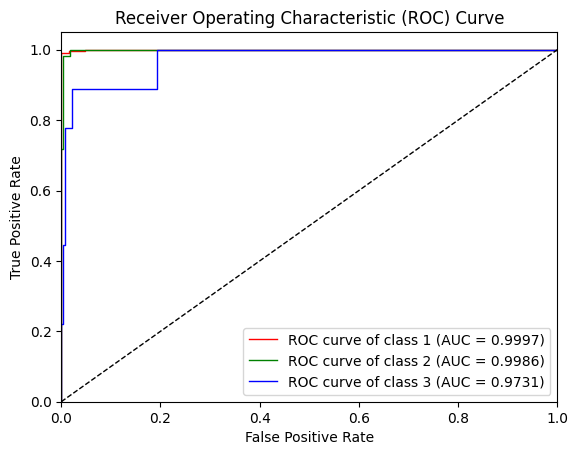

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7882 - auc: 0.8530
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6294 - auc: 0.8838
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6022 - auc: 0.9247
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5849 - auc: 0.9555
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5600 - auc: 0.9616
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5235 - auc: 0.9617
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4673 - auc: 0.9622
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3952 - auc: 0.9623
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3201 - auc: 0.9730
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2570 - auc: 0.9889
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

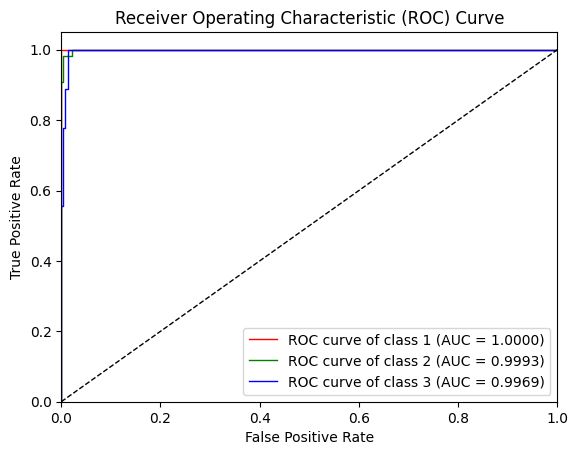

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.7339 - auc: 0.8803
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6128 - auc: 0.8834
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5986 - auc: 0.9082
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5911 - auc: 0.9595
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5800 - auc: 0.9604
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5587 - auc: 0.9624
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5216 - auc: 0.9626
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4619 - auc: 0.9627
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3791 - auc: 0.9627
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2938 - auc: 0.9855
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

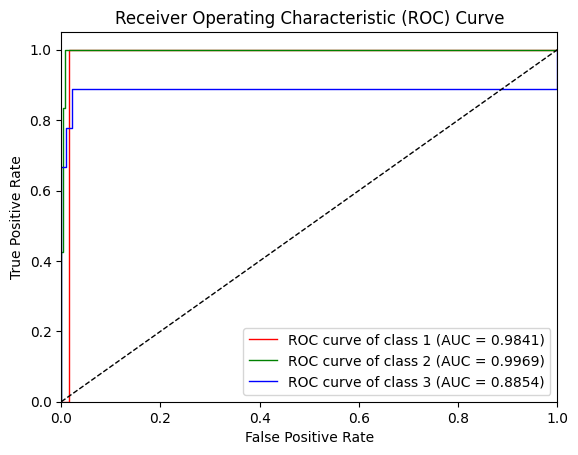

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 1.1612 - auc: 0.4775
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.7325 - auc: 0.8768
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6350 - auc: 0.9337
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5941 - auc: 0.9553
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5616 - auc: 0.9570
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5261 - auc: 0.9567
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4817 - auc: 0.9583
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4292 - auc: 0.9574
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3741 - auc: 0.9636
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3236 - auc: 0.9804
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

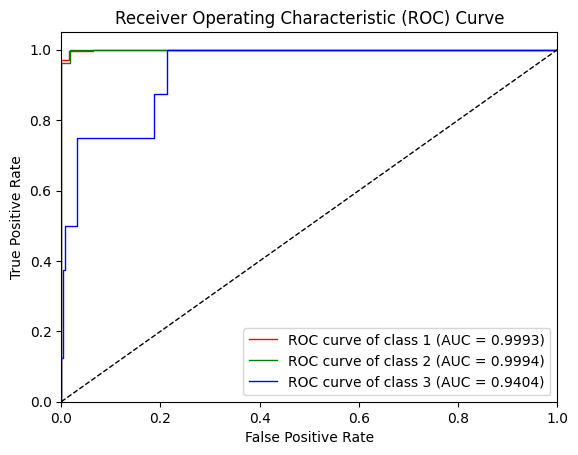

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.9752 - auc: 0.7333
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6712 - auc: 0.8749
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6176 - auc: 0.8942
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6035 - auc: 0.9435
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5934 - auc: 0.9522
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5796 - auc: 0.9568
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5559 - auc: 0.9584
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5170 - auc: 0.9600
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4550 - auc: 0.9624
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3765 - auc: 0.9625
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

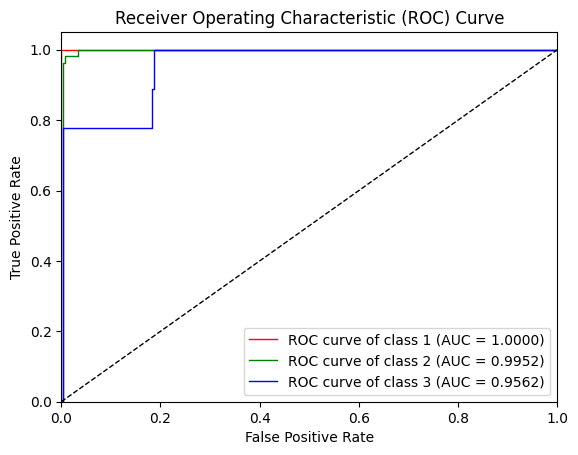

#########################################
Units: 16 Activation Function: sigmoid AUC Média: 0.9776128375118924
#########################################
Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.5951 - auc: 0.9228
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3342 - auc: 0.9789
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1595 - auc: 0.9958
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1138 - auc: 0.9977
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0940 - auc: 0.9983
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0800 - auc: 0.9987
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0680 - auc: 0.9991
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0572 - auc: 0.9991
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0483 - auc: 0.9996
Epoch 10/2

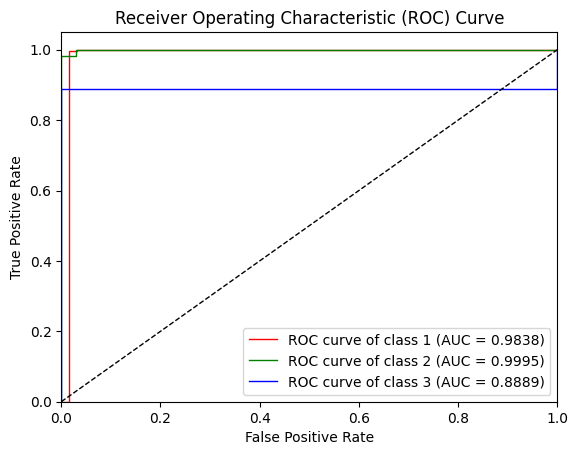

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.6155 - auc: 0.9202
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4449 - auc: 0.9590
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2356 - auc: 0.9946
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1407 - auc: 0.9976
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1098 - auc: 0.9978
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0933 - auc: 0.9981
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0816 - auc: 0.9983
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0716 - auc: 0.9985
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0620 - auc: 0.9987
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0548 - auc: 0.9990
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

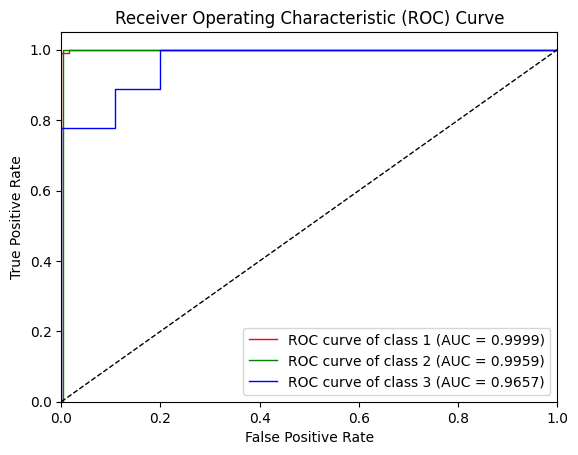

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.4576 - auc: 0.9647
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2114 - auc: 0.9923
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1316 - auc: 0.9970
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1014 - auc: 0.9981
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0827 - auc: 0.9981
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0691 - auc: 0.9982
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0585 - auc: 0.9988
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0511 - auc: 0.9989
Epoch 9/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0449 - auc: 0.9991
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0411 - auc: 0.9992
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

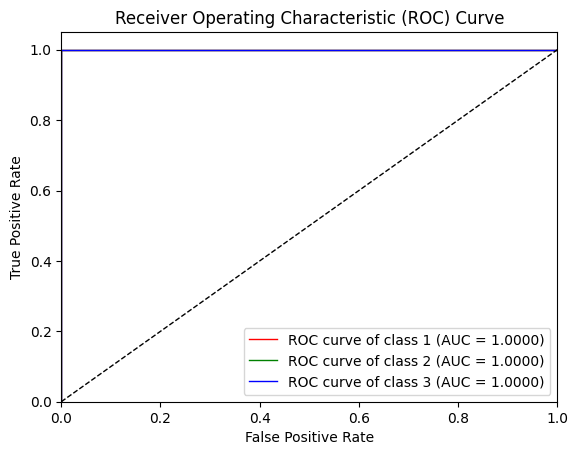

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7109 - auc: 0.9022
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4570 - auc: 0.9584
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2514 - auc: 0.9906
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1569 - auc: 0.9967
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1216 - auc: 0.9979
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1015 - auc: 0.9982
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0873 - auc: 0.9986
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0741 - auc: 0.9988
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0635 - auc: 0.9991
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0535 - auc: 0.9992
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

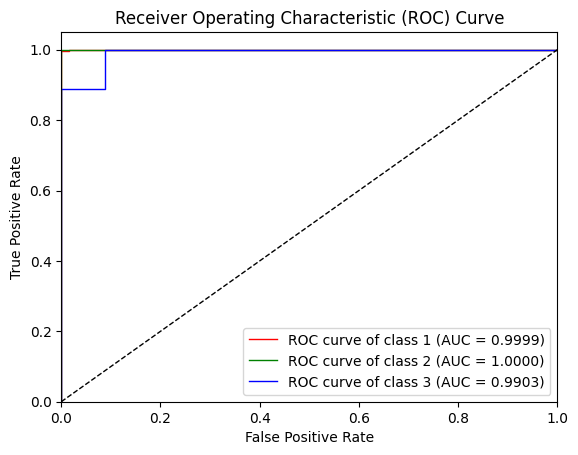

Epoch 1/25
92/92 [==============================] - 2s 3ms/step - loss: 0.8138 - auc: 0.8313
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4823 - auc: 0.9610
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2844 - auc: 0.9860
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1796 - auc: 0.9925
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1407 - auc: 0.9947
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1210 - auc: 0.9971
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1082 - auc: 0.9980
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0985 - auc: 0.9979
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0897 - auc: 0.9978
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0811 - auc: 0.9984
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

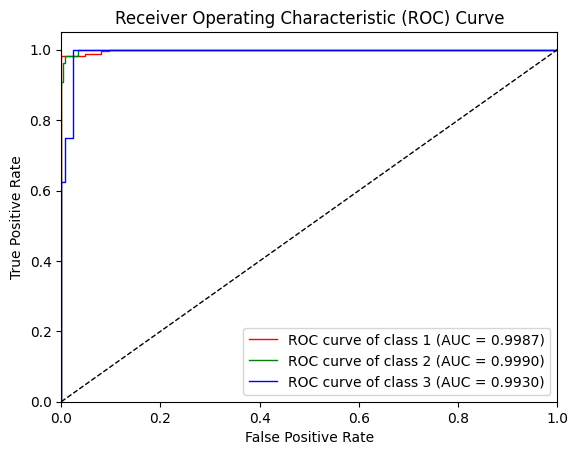

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7929 - auc: 0.8110
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5387 - auc: 0.9559
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3695 - auc: 0.9703
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2120 - auc: 0.9927
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1385 - auc: 0.9963
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1046 - auc: 0.9972
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0864 - auc: 0.9975
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0717 - auc: 0.9978
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0602 - auc: 0.9982
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0527 - auc: 0.9986
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

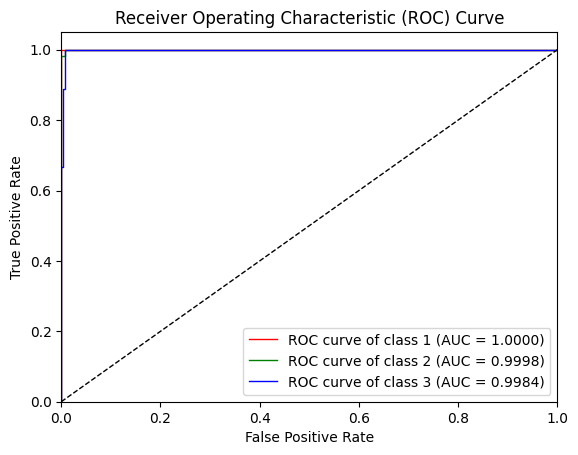

#########################################
Units: 16 Activation Function: tanh AUC Média: 0.9895920528959573
#########################################
Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.8009 - auc: 0.8655
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4424 - auc: 0.9666
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2075 - auc: 0.9930
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1324 - auc: 0.9951
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1130 - auc: 0.9962
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1044 - auc: 0.9968
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0993 - auc: 0.9968
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0949 - auc: 0.9976
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0910 - auc: 0.9976
Epoch 10/25
9

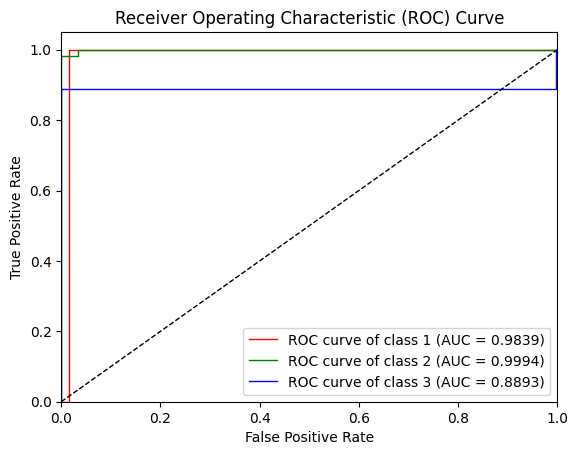

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.7661 - auc: 0.8379
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4184 - auc: 0.9656
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2754 - auc: 0.9888
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1761 - auc: 0.9934
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1269 - auc: 0.9963
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1034 - auc: 0.9974
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0887 - auc: 0.9977
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0771 - auc: 0.9983
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0676 - auc: 0.9985
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0582 - auc: 0.9988
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

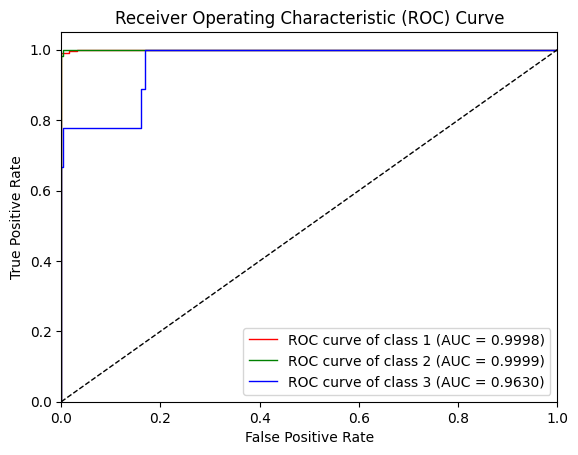

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.9812 - auc: 0.7362
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6600 - auc: 0.9001
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5174 - auc: 0.9608
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3687 - auc: 0.9724
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2304 - auc: 0.9920
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1566 - auc: 0.9940
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1279 - auc: 0.9957
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1158 - auc: 0.9966
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1083 - auc: 0.9974
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1007 - auc: 0.9977
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

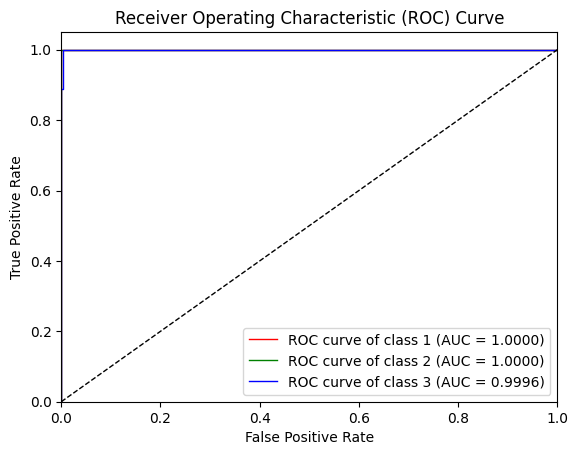

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.9878 - auc: 0.7613
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5691 - auc: 0.9567
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3170 - auc: 0.9752
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.1895 - auc: 0.9912
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1301 - auc: 0.9974
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0979 - auc: 0.9986
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0784 - auc: 0.9989
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0657 - auc: 0.9992
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0560 - auc: 0.9994
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0497 - auc: 0.9996
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

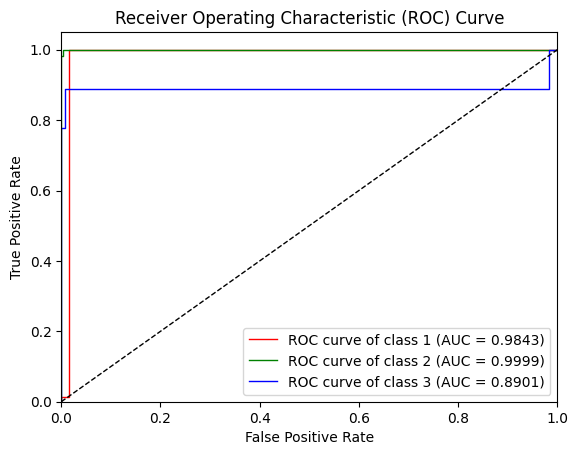

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 1.0590 - auc: 0.6891
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.8496 - auc: 0.8316
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6172 - auc: 0.9245
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3957 - auc: 0.9762
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1773 - auc: 0.9950
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1203 - auc: 0.9976
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1028 - auc: 0.9975
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0905 - auc: 0.9980
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0786 - auc: 0.9984
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0695 - auc: 0.9986
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

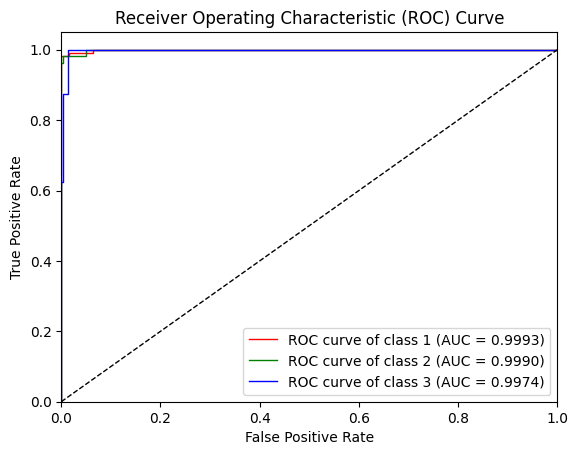

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 1.1265 - auc: 0.5865
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.8974 - auc: 0.9730
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.7024 - auc: 0.9780
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4242 - auc: 0.9851
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1937 - auc: 0.9952
Epoch 6/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1047 - auc: 0.9988
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0692 - auc: 0.9993
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0517 - auc: 0.9992
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0415 - auc: 0.9995
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0346 - auc: 0.9994
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

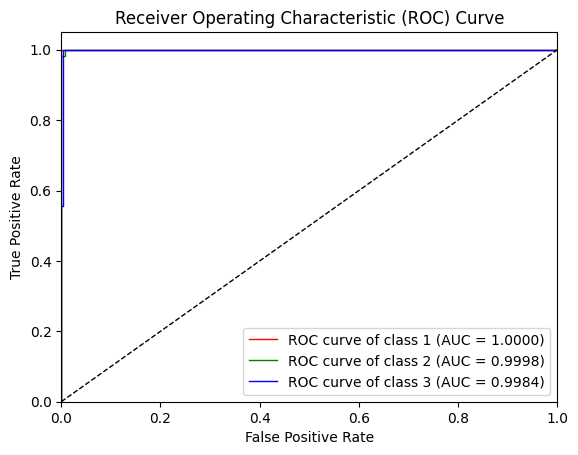

#########################################
Units: 14 Activation Function: relu AUC Média: 0.983503601257957
#########################################
Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.8827 - auc: 0.8501
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6493 - auc: 0.8798
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6098 - auc: 0.8901
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.6018 - auc: 0.9084
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5970 - auc: 0.9465
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5909 - auc: 0.9600
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5817 - auc: 0.9613
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5669 - auc: 0.9625
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5463 - auc: 0.9628
Epoch 10/25
92

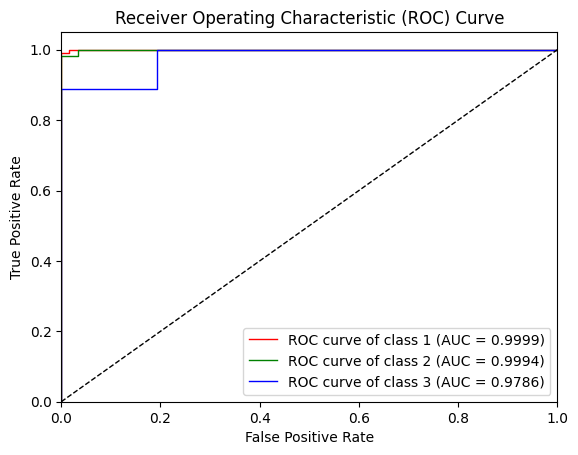

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 1.1290 - auc: 0.5800
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.7681 - auc: 0.8358
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6739 - auc: 0.8856
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6307 - auc: 0.9562
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6034 - auc: 0.9589
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5811 - auc: 0.9607
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5568 - auc: 0.9617
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5280 - auc: 0.9615
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4918 - auc: 0.9615
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4487 - auc: 0.9614
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

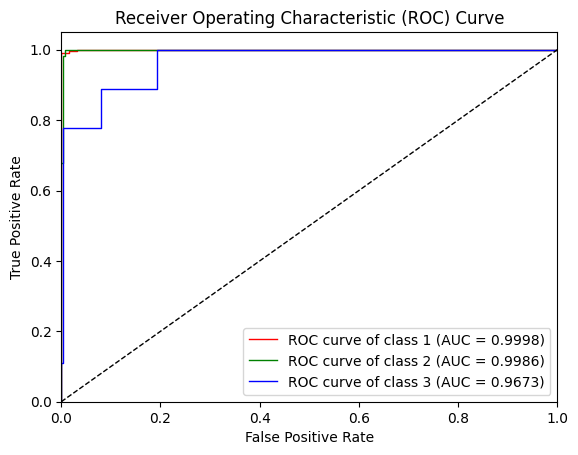

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.6449 - auc: 0.8729
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6047 - auc: 0.8769
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5941 - auc: 0.9266
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5759 - auc: 0.9592
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5461 - auc: 0.9610
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5015 - auc: 0.9617
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4412 - auc: 0.9620
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3715 - auc: 0.9622
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3044 - auc: 0.9789
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2511 - auc: 0.9890
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

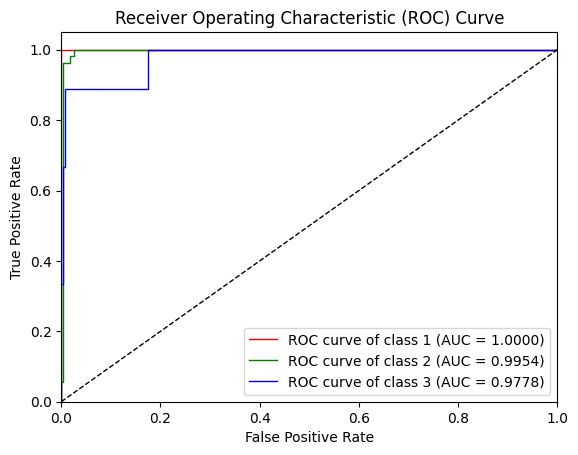

Epoch 1/25
92/92 [==============================] - 2s 3ms/step - loss: 0.8867 - auc: 0.7194
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6521 - auc: 0.8731
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6080 - auc: 0.8896
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5985 - auc: 0.9261
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5896 - auc: 0.9577
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5754 - auc: 0.9593
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5493 - auc: 0.9615
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5076 - auc: 0.9618
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4524 - auc: 0.9623
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3861 - auc: 0.9627
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

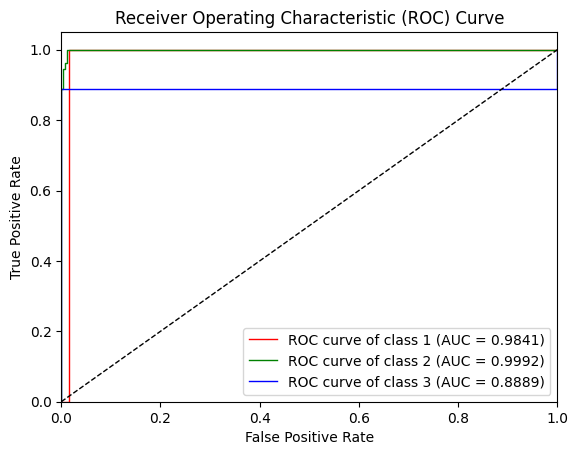

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7972 - auc: 0.8682
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6468 - auc: 0.8983
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6097 - auc: 0.9304
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5947 - auc: 0.9547
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5816 - auc: 0.9556
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5596 - auc: 0.9586
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5246 - auc: 0.9612
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4758 - auc: 0.9620
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4157 - auc: 0.9618
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.3528 - auc: 0.9626
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

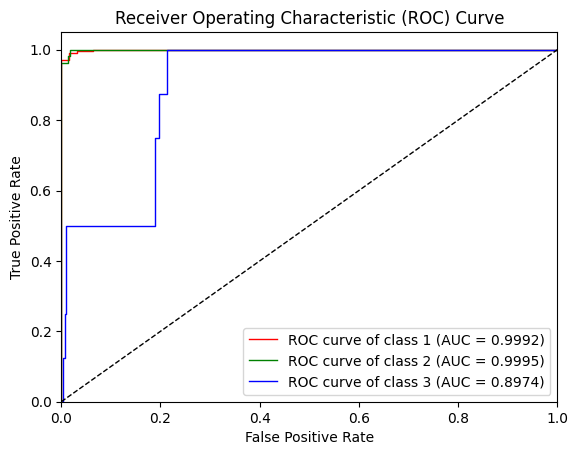

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7644 - auc: 0.8777
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.6341 - auc: 0.9017
Epoch 3/25
92/92 [==============================] - 0s 2ms/step - loss: 0.6036 - auc: 0.9391
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.5887 - auc: 0.9581
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5721 - auc: 0.9590
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5447 - auc: 0.9617
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.4989 - auc: 0.9622
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4330 - auc: 0.9623
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3548 - auc: 0.9634
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2847 - auc: 0.9808
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

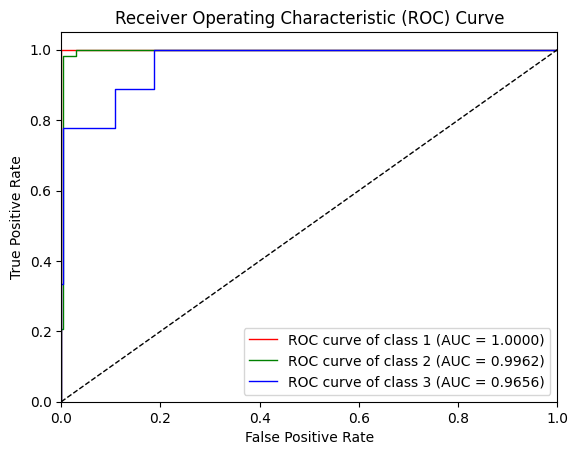

#########################################
Units: 14 Activation Function: sigmoid AUC Média: 0.9803707688622524
#########################################
Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.5444 - auc: 0.9408
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2726 - auc: 0.9890
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1656 - auc: 0.9939
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1274 - auc: 0.9965
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1115 - auc: 0.9969
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1027 - auc: 0.9974
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0966 - auc: 0.9978
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0915 - auc: 0.9978
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0868 - auc: 0.9981
Epoch 10/2

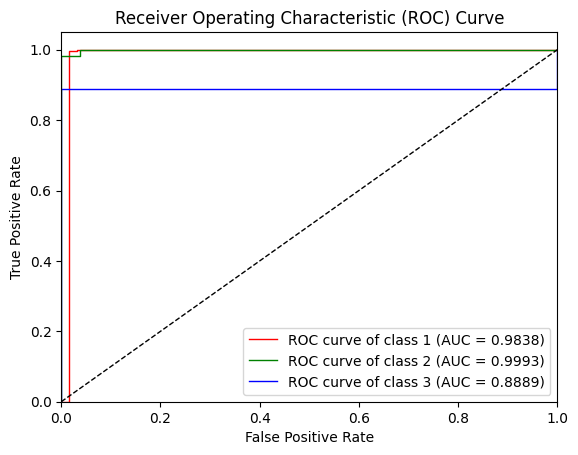

Epoch 1/25
92/92 [==============================] - 2s 3ms/step - loss: 0.6847 - auc: 0.8747
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4967 - auc: 0.9569
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3082 - auc: 0.9799
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1698 - auc: 0.9945
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1192 - auc: 0.9970
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0957 - auc: 0.9974
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0803 - auc: 0.9975
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0675 - auc: 0.9981
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0583 - auc: 0.9984
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0508 - auc: 0.9984
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

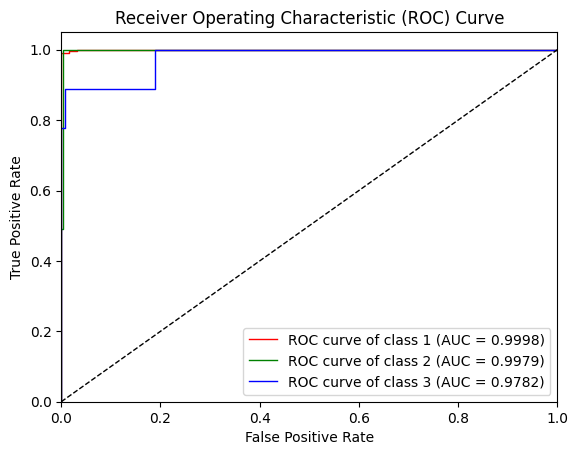

Epoch 1/25
92/92 [==============================] - 2s 3ms/step - loss: 0.6583 - auc: 0.9061
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4454 - auc: 0.9622
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2781 - auc: 0.9889
Epoch 4/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1719 - auc: 0.9944
Epoch 5/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1273 - auc: 0.9963
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1044 - auc: 0.9972
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0877 - auc: 0.9979
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0752 - auc: 0.9983
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0640 - auc: 0.9984
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0554 - auc: 0.9987
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

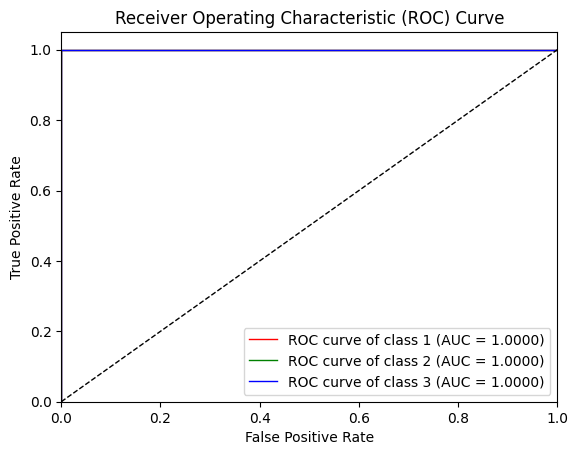

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.8230 - auc: 0.7927
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.5928 - auc: 0.8935
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4772 - auc: 0.9592
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2760 - auc: 0.9876
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1606 - auc: 0.9948
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1224 - auc: 0.9967
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1051 - auc: 0.9976
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0924 - auc: 0.9982
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0825 - auc: 0.9985
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0722 - auc: 0.9988
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

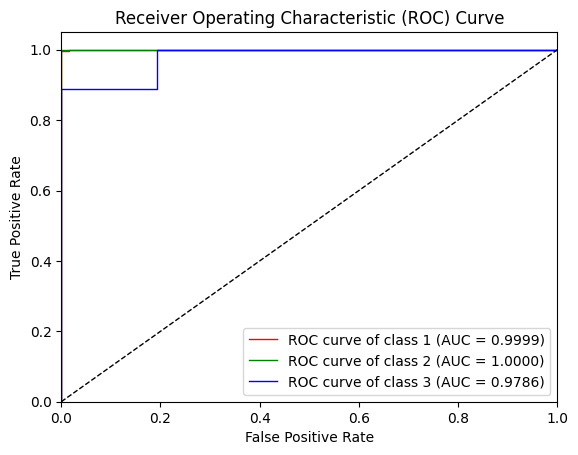

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.6696 - auc: 0.9304
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3691 - auc: 0.9866
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1973 - auc: 0.9960
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1366 - auc: 0.9974
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.1119 - auc: 0.9977
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0957 - auc: 0.9981
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0833 - auc: 0.9982
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.0720 - auc: 0.9986
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0620 - auc: 0.9988
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0531 - auc: 0.9994
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

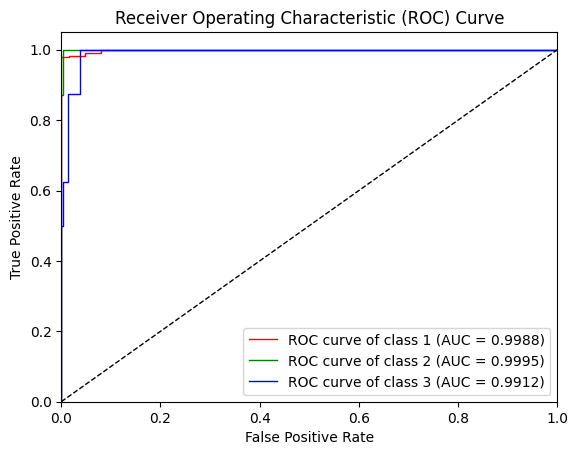

Epoch 1/25
92/92 [==============================] - 1s 3ms/step - loss: 0.7665 - auc: 0.8534
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4433 - auc: 0.9671
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2761 - auc: 0.9893
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1825 - auc: 0.9943
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1379 - auc: 0.9959
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1153 - auc: 0.9969
Epoch 7/25
92/92 [==============================] - 0s 2ms/step - loss: 0.1007 - auc: 0.9970
Epoch 8/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0897 - auc: 0.9974
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.0819 - auc: 0.9981
Epoch 10/25
92/92 [==============================] - 0s 2ms/step - loss: 0.0751 - auc: 0.9978
Epoch 11/25
92/92 [==============================] - 0s 2ms/step - lo

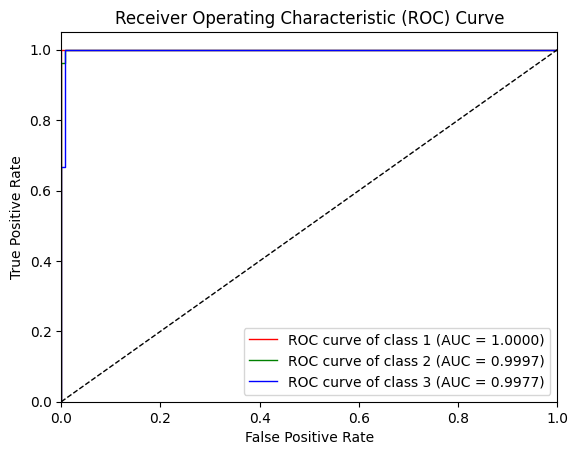

#########################################
Units: 14 Activation Function: tanh AUC Média: 0.9896198097241742
#########################################


In [ ]:
dados = X
rotulos = y
# Definir o número de folds para a validação cruzada
k = 6

lw = 1

# inicializar a lista para armazenar os tempos de treinamento
training_times = []

Probabilidades = []
Agrega_Resultado = []

# Criar o objeto para realizar a validação cruzada k-fold estratificado
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

#Parametros de Busca
activation_funcs = [relu, sigmoid, tanh]
units_list = [20, 18, 16, 14]

# Loop para treinar e avaliar o modelo em cada fold
for units in units_list:
    for activation_func in activation_funcs:
        for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):

            # Separar os dados em treino e teste para o fold atual
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # converte rótulos para formato one-hot encoding
            y_train = to_categorical(y_train, num_classes=3)
            y_test = to_categorical(y_test, num_classes=3)

            model = []
            del model

            #Construção do modelo
            model = Sequential()
            model.add(Dense(units=units, input_dim=25, activation=activation_func))
            model.add(Dense(units=units/2, activation=activation_func))
            model.add(Dense(units=3, activation='softmax'))

            # Compilar o modelo
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['AUC'])

            # armazenar o tempo de início do treinamento
            start_time = time.time()

            # Treinar o modelo com os dados de treino do fold atual
            model.fit(X_train, y_train, batch_size=16, epochs=25)

            # armazenar o tempo de fim do treinamento
            end_time = time.time()

            # calcular o tempo de treinamento em segundos
            training_time = end_time - start_time

            # armazenar o tempo de treinamento na lista
            training_times.append(training_time)

            y_proba = model.predict(X_test)

            Probabilidades.append(y_proba)

            # Converter previsões em classes
            y_pred_classes = np.argmax(y_proba, axis=1)

            # Converter rótulos de teste em classes
            y_true = np.argmax(y_test, axis=1)
            y_true_treino = np.argmax(y_train, axis=1)
            cm = confusion_matrix(y_true, y_pred_classes)

            print(f"Fold {fold_idx + 1}: {len(X_train)} Amostras de Treino ({len(np.where(y_true_treino == 0)[0])} Arritimia (1), {len(np.where(y_true_treino == 1)[0])} Arritimia (2), {len(np.where(y_true_treino == 2)[0])} Arritimia (3) e {len(np.where(y_true_treino == 3)[0])} Arritimia (4))")
            print(f"Fold {fold_idx + 1}: {len(X_test)} Amostras de Teste ({len(np.where(y_true == 0)[0])} Arritimia (1), {len(np.where(y_true == 1)[0])} Arritimia (2), {len(np.where(y_true == 2)[0])} Arritimia (3) e {len(np.where(y_true == 3)[0])} Arritimia (4))")

            # Exibir informações sobre os dados de treino e teste do fold atual
            print(f"Fold {fold_idx + 1}: Tempo Treinamento = {training_time:.4f}")
            print("______________")
            print(f"Fold {fold_idx + 1} - Matriz de Confusão")
            print(cm)
            print("______________")

            n_classes = y_test.shape[1]
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            AUC_M = []
            for i in range(n_classes):
              fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i])

              roc_auc[i] = auc(fpr[i], tpr[i])
              print(f"Fold {fold_idx + 1}: AUC classe {i+1} = {roc_auc[i]:.4f}")
              AUC_M.append(roc_auc[i])

            mean_auc = np.mean(AUC_M)
            print(f"Fold {fold_idx + 1}: AUC Média = {mean_auc:.4f}")
            print("______________")

            Agrega_Resultado.append(mean_auc)

            # plotar as curvas ROC
            plt.figure()
            colors = ['red', 'green', 'blue', 'orange']
            for i, color in zip(range(n_classes), colors):
              plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                      label='ROC curve of class {0} (AUC = {1:0.4f})'
                    ''.format(i+1, roc_auc[i]))
            plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()

        Res_Fold_Médio = np.mean(Agrega_Resultado)
        Agrega_Resultado = []
        # Resultado
        print('#########################################')
        print('Units:', units, 'Activation Function:', activation_func.__name__, 'AUC Média:', Res_Fold_Médio)
        print('#########################################')


        # Redireciona a saída de impressão para a saída padrão novamente

# E N T R E N A M I E N T O

Entrenamos un MLP para clasificar tres clases de sismos

In [12]:
#np.random.seed(23)

dim_entrada = X.shape[1]
entrada = Input(shape=(dim_entrada,))

print(X.shape[1])
x = Dense(14, activation='relu')(entrada)
saida = Dense(3, activation='softmax')(x)
clasificador = Model(inputs=entrada, outputs=saida)
clasificador.summary()

25
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense (Dense)               (None, 14)                364       
                                                                 
 dense_1 (Dense)             (None, 3)                 45        
                                                                 
Total params: 409 (1.60 KB)
Trainable params: 409 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
'''
y_label = []
for i in range(len(y)):
  if y[i,0] > 0:
    y_label.append(0)
  if y[i,1] > 0:
    y_label.append(1)
  if y[i,2] > 0:
    y_label.append(2)
y_label = np.array(y_label)
print(y_label.shape)
'''

(1762,)


# Implementando Validación Cruzada Estratificada y Clasificación

In [13]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

Definimos la configuracipon de Validacipon Cruzada estratificada y luego el modelo de clasificación:

# Aplicando CrossValidation en los datos PCA

StratifiedShuffleSplit(n_splits=6, random_state=True, test_size=None,
            train_size=None)
TRAIN: [ 811  837  966 ... 1662 1126  900] TEST: [1129 1224 1555  779   94 1678  327 1182 1621  185  178  749  312  257
  585  617  199  202  586 1044  416  703  609  731  697 1697  818  899
  795 1265 1071 1698  895  587 1596  341 1267  946 1173  937  889 1576
 1313  389  949  215  173 1754  407 1684  395  630  998 1309 1516  642
 1546 1116  485  917  903  292  677 1348  386  651  604  158  793  644
  820  324 1537   16  846 1638 1122 1718 1549  294 1581 1087  877  802
  944   22  170 1191 1723  330  755   84 1668  798 1410  472 1659 1220
 1334  400 1154  974  496 1695  250  503  343  788  182  942  538 1356
  140  771 1392  117  308  208 1654  231 1390  782 1409  738  711 1135
  578 1734 1573  118 1437  549 1622  705 1660  441  665 1382  574 1454
  157 1068 1399 1332  634  387 1484 1657 1395 1637  284 1290 1701 1310
 1427  766 1634 1469 1096  383  249 1142  732  989 1624 1180 1496 1319


TRAIN: [1072 1192 1108 ... 1418  462 1468] TEST: [1360 1459 1229   29  326  885  787 1044  281  781  280 1223 1504 1367
  319 1610 1473  166 1343  337  806  153 1047 1346    8  238 1305 1332
 1587  738  737 1151  996  619  698  135 1091 1212  346  829 1664   41
 1166  160 1440 1712  531  715 1563  526  447  497  761 1193 1716  596
  976  466  509 1310 1462 1391 1381 1099  419  431  909 1024 1106  800
  205  168  218  913 1314   75  370   89 1093 1350  544  675  600 1472
 1285  393  581 1261  878  116 1758  584 1631   66  394 1483  788 1354
  764  489  622  309  525  775  465  518 1619  834  365  962  955  923
  542  311  937 1550  871 1749 1406  314  717 1688 1515  578  709 1606
  850  118  993 1557 1683  712  939 1409  175  508  970  571 1302 1136
 1694  190  606 1026 1715 1759   40 1746  460   26 1422  907  108 1207
  892 1506  610 1650  893  908 1235 1023  972 1048 1104  695  158 1009
 1397  334 1519  415   63 1400 1442  932 1395]
Epoch 1/25
106/106 [==============================] 

TRAIN: [1404 1460  110 ...  904  189  379] TEST: [  84  500  882  532   47  590 1263  689 1337 1761  408  582  694 1226
 1487  888  953  579 1326 1468  515  887 1244 1247 1657 1385 1176 1324
  771 1456  870  619 1454 1032  815 1140  773  463 1121 1587 1424 1688
  380  203 1530 1707 1347   64  629  194  462  843  106 1426  316  357
 1455  867  574 1545 1691  996  868  304 1565  700  217 1399  737  244
 1531  609 1502  243  839 1289 1519  509  474 1500  225  741  280    4
  236 1492  115  147 1348  191 1008 1708  988 1285  159 1058  696 1261
 1588  531 1444  187 1061 1642 1554 1470  172 1534  778 1365 1524 1661
   45   69 1276 1350  341  161  436 1196  903 1429  890  567  164  958
 1586  149  477  948  767  757 1659 1370 1610 1564  834 1704  811  818
 1084 1682 1284 1231  646  343 1683  480  848 1209 1405 1314 1230 1755
   26  421 1380 1019 1137 1051 1015 1088  129   99  326  558 1664    1
  155  538  163  786 1447   85  208 1558 1506]
Epoch 1/25
106/106 [==============================] 

TRAIN: [1065  345  831 ...  580  655 1419] TEST: [ 449   83  283  900 1120  388    0  316  726  819 1014 1562   68  592
  269 1007  289 1612 1740 1591 1574  689  674  673  233 1589 1289 1436
 1404 1276 1613  634 1051  189  556   79  247  826  957 1510  468 1056
  300  603   85 1047 1135 1399  884 1378  602   20  254 1142 1097  521
  683  496   76 1670  511 1081  581  144  199 1532  635  413  731 1761
  691 1128 1346  733  297 1019 1374  974 1396 1754 1483  224 1584 1744
  952  834  140  371 1373 1317 1299 1252   91 1356  772  606 1432  699
  407  866  648  515 1576  188   28 1410  237  298 1499  705  460 1291
  730  722  803 1611 1424  408 1457  841 1174  250  663  667 1726  708
  393  567 1750  169 1653  540  836 1509 1104 1406  555  484 1544 1353
  848 1466 1187  513 1277 1215 1027 1511 1377  510 1201 1236 1321  860
  436 1296 1479  698  155 1077  191 1186 1347 1640  367  888 1082 1684
  782 1122  206  893   32 1106 1556  593   24]
Epoch 1/25
106/106 [==============================] 

TRAIN: [ 888  260 1108 ...  210 1038   97] TEST: [1610  854 1164 1537  788 1704  250  399  433 1550  787 1454  882 1113
 1673 1394  156 1713  704 1607  591 1688 1159 1641  517  488   35  407
 1751 1366  309 1533  216  503  526 1283  799  781 1627 1567 1028 1006
  209  267 1214 1203  681 1676 1268 1368 1554  219  335  333  363  258
  703  736  994  626  673 1085  841  116 1480   71 1429  103 1711 1135
 1692 1418   22 1683 1427 1459  524   20 1234  670  973 1348  315  424
 1197   69 1380  660 1121  138 1522  112  181  980  832  225 1279  807
  671 1323 1042  301  543   12  371  343 1542  452 1629  456 1147 1482
  795  480  504  213  675 1003 1396  470  998 1165  206  396 1168  175
  690  865 1474 1276  393  212 1494   43  612  831 1549 1651  654 1066
  910  712  813   73  662 1039 1664  541  473  945  710  619 1343  531
 1322   59 1602 1338 1170  286  370  958  566 1586  291  692  561  827
 1068  230  730  684  549 1090  512  403  236]
Epoch 1/25
106/106 [==============================] 

TRAIN: [1110 1337  959 ... 1755  651 1679] TEST: [ 325  498 1338 1447 1502 1090  700  852 1032  935  722 1470 1078  130
 1181 1026 1097 1322  438  558  878  768  355  604 1461 1142  369  541
  969  825  564 1374 1517 1585 1298  668  448  341  483  122  964   56
 1170  613  769 1719 1624  226 1233 1591 1650  153  530 1713 1685  482
  557  431 1740  287 1528  528 1155  326  979 1079  447  804  993  711
  301  376 1334  974  954 1158 1634 1422 1534 1225 1036  573 1450  422
 1295 1218 1546 1533  288 1287 1343  285  401  233 1159 1606  293 1060
  105 1205  500  247  783 1247  493  231  931  304 1661 1065 1105  923
  411  522 1569  383  696  839 1474  894  205  848   70 1597  915  602
  982  579  746  427  486  365  566  990  390 1134  778  492  442  780
  263  970 1560  425   32  997  705 1188 1255 1509  340  543 1539 1387
 1456  560 1697 1122  658 1494 1521  228  759  404 1011  428  135  516
 1053  834 1615 1048  234 1215  625  202 1101]
Epoch 1/25
106/106 [==============================] 

train -  [1248  289   48]   |   test -  [140  32   5]
train -  [1248  289   48]   |   test -  [140  32   5]
train -  [1248  289   48]   |   test -  [140  32   5]
train -  [1248  289   48]   |   test -  [140  32   5]
train -  [1248  289   48]   |   test -  [140  32   5]
train -  [1248  289   48]   |   test -  [140  32   5]


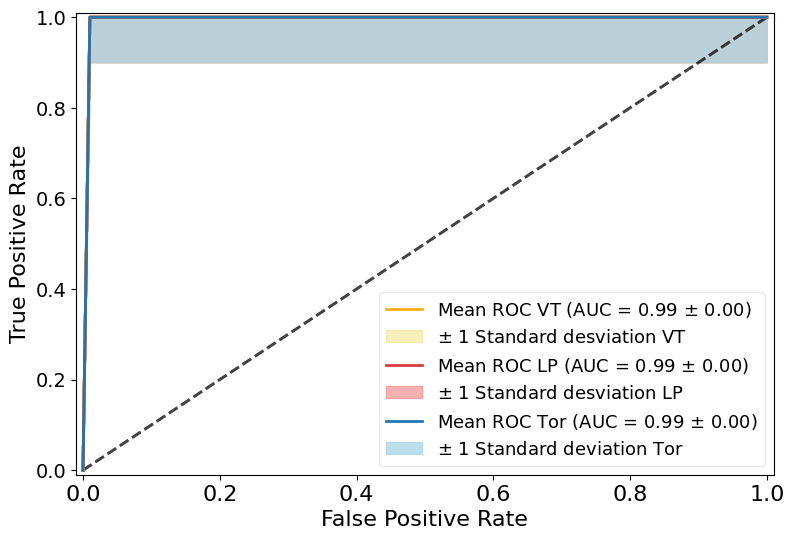

<Figure size 600x600 with 0 Axes>

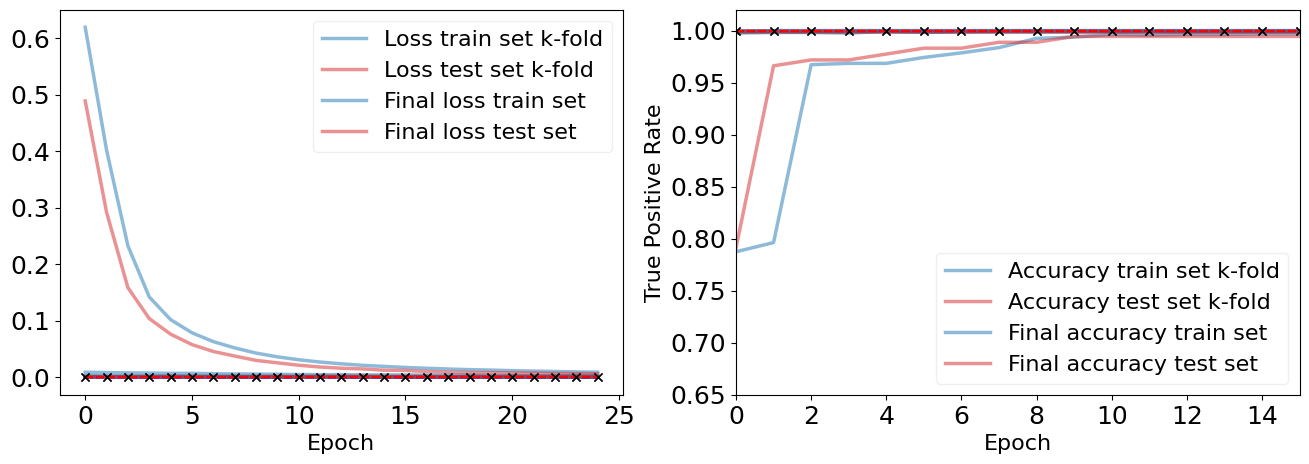

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

cv = StratifiedShuffleSplit(n_splits=6, random_state=True)
th_0 = []
th_1 = []
th_2 = []

y = np.round(y).astype(int)

print(cv)
StratifiedShuffleSplit(n_splits=6, random_state=True)

fig, ax = plt.subplots(1, figsize = (9, 6))
tprs_mean_0 = []
tprs_mean_1 = []
tprs_mean_2 = []
aucs_0 = []
aucs_1 = []
aucs_2 = []

corte0 = []
corte1 = []
corte2 = []
fold = 1

for train_index, test_index in cv.split(X, y):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # converte rótulos para formato one-hot encoding
  y_train = to_categorical(y_train, num_classes=3)
  y_test = to_categorical(y_test, num_classes=3)

  clasificador = Model(inputs=entrada, outputs=saida)
  clasificador.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'AUC'])
  # armazenar o tempo de início do treinamento
  time
  start_time = time.time()
  historia = clasificador.fit(X_train, y_train,
                           epochs=25,
                           batch_size=15,
                           validation_data=(X_test, y_test),
                           shuffle=True)
  # armazenar o tempo de fim do treinamento
  end_time = time.time()

  print("ENTRENAMIENTO EN EL FOLD %0.2f" %(fold))
  y_pred = clasificador.predict(X_test)

  tprs = []
  Corte = []
  thresholds = []

  base_fpr = np.linspace(0, 1, 101)
  mean_fpr = np.linspace(0, 1, 100)


  #Curva ROC para la clase VT

  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 0],  y_pred[:,0])
    auc1 = roc_auc_score(y_test[:, 0], y_pred[:, 0])

    # Elegir el umbral óptimo basado en una métrica (por ejemplo, F1-score)
    f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
    best_threshold = th[np.argmax(f1_scores)]

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_0.append(auc1)
  th_0.append(best_threshold)  ##################################################################################

  Corte.append(th[np.argmax(tpr - fpr)])
  corte0.append(Corte)  #########################################################################################
  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k",
          alpha=0.2)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="orange",
      lw=2,
      alpha=0.9,
  )
  tprs_mean_0.append(mean_tpr)

  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.ylabel('True Positive Rate', fontsize=16)
  plt.xlabel('False Positive Rate', fontsize=16)


  #Curva ROC para la clase LP

  tprs = []
  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 1],  y_pred[:, 1])
    auc1 = roc_auc_score(y_test[:, 1], y_pred[:, 1])

    # Elegir el umbral óptimo basado en una métrica (por ejemplo, F1-score)
    f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
    best_threshold = th[np.argmax(f1_scores)]

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_1.append(auc1)
  th_1.append(best_threshold) ##################################################################################

  Corte.append(th[np.argmax(tpr - fpr)])
  corte1.append(Corte)  ########################################################################################

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="lightcoral",
      lw=2,
      alpha=0.99, # alpha es transparencia
  )
  tprs_mean_1.append(mean_tpr)

  #Curva ROC para la clase Tor

  tprs = []
  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 2],  y_pred[:, 2])
    auc1 = roc_auc_score(y_test[:, 2], y_pred[:, 2])

    # Elegir el umbral óptimo basado en una métrica (por ejemplo, F1-score)
    f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
    best_threshold = th[np.argmax(f1_scores)]

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_2.append(auc1)
  th_2.append(best_threshold) ##################################################################################

  Corte.append(th[np.argmax(tpr - fpr)])
  corte2.append(Corte)  ########################################################################################

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="lightblue",
      lw=2,
  )

  tprs_mean_2.append(mean_tpr)
  ax.legend(loc="lower right",fontsize = 8)
  plt.xticks(fontsize=16), plt.yticks(fontsize=14)


  import matplotlib.pyplot as plt
  plt.figure(5, figsize=(16,5))
  plt.subplot(1,2,1)
  plt.plot(historia.history["loss"], color = 'tab:blue', alpha = 0.5, lw = 2.5)   #label="Pérdida train (Fold %0.2f)" %(fold)
  plt.plot(historia.history["val_loss"], color = 'tab:red', alpha = 0.5, lw = 2.5)
  plt.subplot(1,2,2)
  plt.plot(historia.history["categorical_accuracy"], color = 'tab:blue', alpha = 0.5, lw = 2.5)
  plt.plot(historia.history["val_categorical_accuracy"], color = 'tab:red', alpha = 0.5, lw = 2.5)

  fold = fold + 1

for train, test in cv.split(X, y):
  print('train -  {}   |   test -  {}'.format(
      np.bincount(y[train]), np.bincount(y[test])))

plt.figure(3, figsize=(6,6))
tpr_0_final = np.mean(tprs_mean_0, axis=0)
std_tpr_0 = np.std(tpr_0_final, axis=0)
tprs_upper_0 = np.minimum(tpr_0_final + std_tpr_0, 1)
tprs_lower_0 = np.maximum(tpr_0_final - std_tpr_0, 0)

tpr_0_final[-1] = 1.0
mean_auc_0 = auc(mean_fpr, tpr_0_final)
std_auc_0 = np.std(aucs_0)
ax.plot(
    mean_fpr,
    tpr_0_final,
    color="orange",
    label=r"Mean ROC VT (AUC = %0.2f $\pm$ %0.2f)" %(mean_auc_0, std_auc_0),
    lw=2,
    alpha=0.9,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_0,
    tprs_upper_0,
    color="khaki",
    alpha=0.6,
    label="$\pm$ 1 Standard desviation VT",
)

tpr_1_final = np.mean(tprs_mean_1, axis=0)
std_tpr_1 = np.std(tpr_1_final, axis=0)
tprs_upper_1 = np.minimum(tpr_1_final + std_tpr_1, 1)
tprs_lower_1 = np.maximum(tpr_1_final - std_tpr_1, 0)

tpr_1_final[-1] = 1.0
mean_auc_1 = auc(mean_fpr, tpr_0_final)
std_auc_1 = np.std(aucs_1)
ax.plot(
    mean_fpr,
    tpr_1_final,
    color="tab:red",
    label=r"Mean ROC LP (AUC = %0.2f $\pm$ %0.2f)" %(mean_auc_1, std_auc_1),
    lw=2,
    alpha=0.9,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_1,
    tprs_upper_1,
    color="lightcoral",
    alpha=0.6,
    label="$\pm$ 1 Standard desviation LP",
)

tpr_2_final = np.mean(tprs_mean_2, axis=0)
std_tpr_2 = np.std(tpr_2_final, axis=0)
tprs_upper_2 = np.minimum(tpr_2_final + std_tpr_2, 1)
tprs_lower_2 = np.maximum(tpr_2_final - std_tpr_2, 0)

tpr_2_final[-1] = 1.0
mean_auc_2 = auc(mean_fpr, tpr_2_final)
std_auc_2 = np.std(aucs_2)
ax.plot(
    mean_fpr,
    tpr_2_final,
    color="tab:blue",
    label=r"Mean ROC Tor (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc_2, std_auc_2),
    lw=2,
    alpha=0.99,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_2,
    tprs_upper_2,
    color="lightblue",
    alpha=0.8,
    label=r"$\pm$ 1 Standard deviation Tor",
)

ax.legend(loc="lower right",fontsize = 13, fancybox=True, framealpha=0.4)

ax.figure.savefig('ROC_PCA3.pdf', dpi=400, format='pdf')


plt.figure(5, figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], 'xb--',mec='k', lw=1.5)
plt.plot(historia.history["val_loss"], 'xr--',mec='k', lw=1.5)
plt.xlabel('Epoch', fontsize=16)
plt.xticks(fontsize=18), plt.yticks(fontsize=18)
plt.legend(labels=["Loss train set k-fold",
                   "Loss test set k-fold",
                   "Final loss train set",
                   "Final loss test set"],
           fontsize='16', fancybox=True, framealpha=0.3)
plt.subplot(1,2,2)
plt.plot(historia.history["categorical_accuracy"], 'xb--',mec='k', lw=1.5)
plt.plot(historia.history["val_categorical_accuracy"], 'xr--',mec='k', lw=1.5)
plt.xlim(0, 15)
plt.ylim(0.65, 1.02)
plt.xlabel('Epoch', fontsize=16)
plt.legend(labels=["Accuracy train set k-fold",
                   "Accuracy test set k-fold",
                   "Final accuracy train set",
                   "Final accuracy test set"],
           fontsize='16', fancybox=True, loc='lower right', framealpha=0.3)
plt.xticks(fontsize=18), plt.yticks(fontsize=18)

plt.savefig('CrossVall_PCA.pdf', dpi=400, format='pdf')

Gráfico de umbrales que se generaron durante el cálculo de la curva ROC

In [15]:
corte0

[[0.97652215, 0.938095, 0.8869324],
 [0.9387068, 0.96952784, 0.9829261],
 [0.9994601, 0.98376065, 0.9966592],
 [0.99994534, 0.8783535, 0.9944482],
 [0.8664084, 0.9892968, 0.9986426],
 [0.99909365, 0.9753439, 0.9998193]]

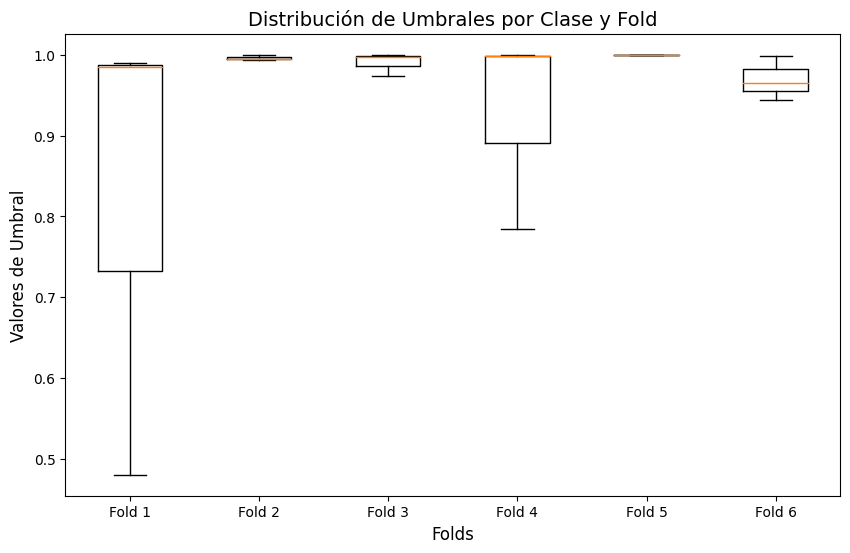

In [15]:
import seaborn as sns
# Clases y etiquetas para los boxplots
clases = ['Clase VT', 'Clase LP', 'Clase TOR']
etiquetas = [f'Fold {i+1}' for i in range(len(corte0))]
data = np.array(corte0)
# Crear el boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data.T, labels=etiquetas)
plt.xlabel('Folds', fontsize=12)
plt.ylabel('Valores de Umbral', fontsize=12)
plt.title('Distribución de Umbrales por Clase y Fold', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Gráfica con la tendencia de los umbrales

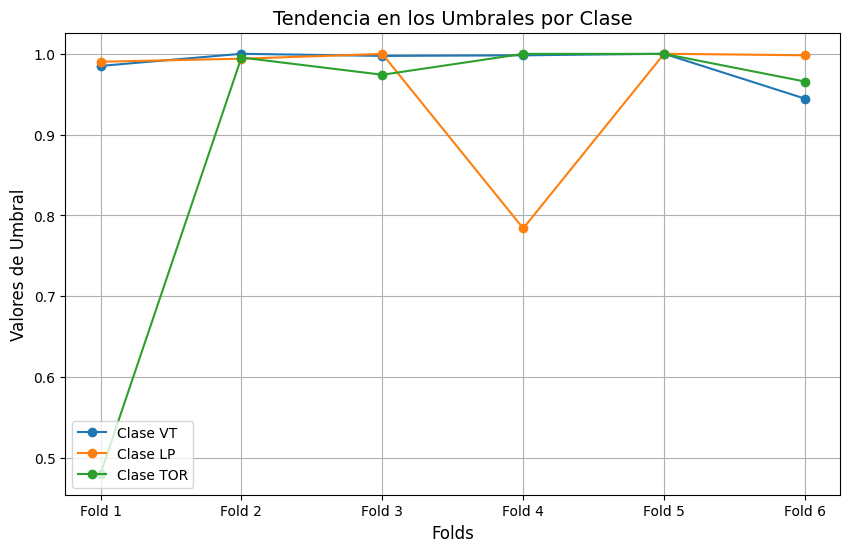

In [16]:
# Umbrales por clase y fold (como listas de listas)
umbrales_clase_VT = [fila[0] for fila in corte0]
umbrales_clase_LP = [fila[1] for fila in corte0]
umbrales_clase_Tor = [fila[2] for fila in corte0]

# Valores de los folds (etiquetas)
folds = [f'Fold {i+1}' for i in range(len(umbrales_clase_VT))]

# Crear gráfico de líneas para mostrar tendencia
plt.figure(figsize=(10, 6))
plt.plot(folds, umbrales_clase_VT, marker='o', label='Clase VT')
plt.plot(folds, umbrales_clase_LP, marker='o', label='Clase LP')
plt.plot(folds, umbrales_clase_Tor, marker='o', label='Clase TOR')
plt.xlabel('Folds', fontsize=12)
plt.ylabel('Valores de Umbral', fontsize=12)
plt.title('Tendencia en los Umbrales por Clase', fontsize=14)
plt.legend(loc='lower left', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

Gráfico umbrales para *f1-score* por clase, para ver la distribución de los umbrales en los diferentes folds.

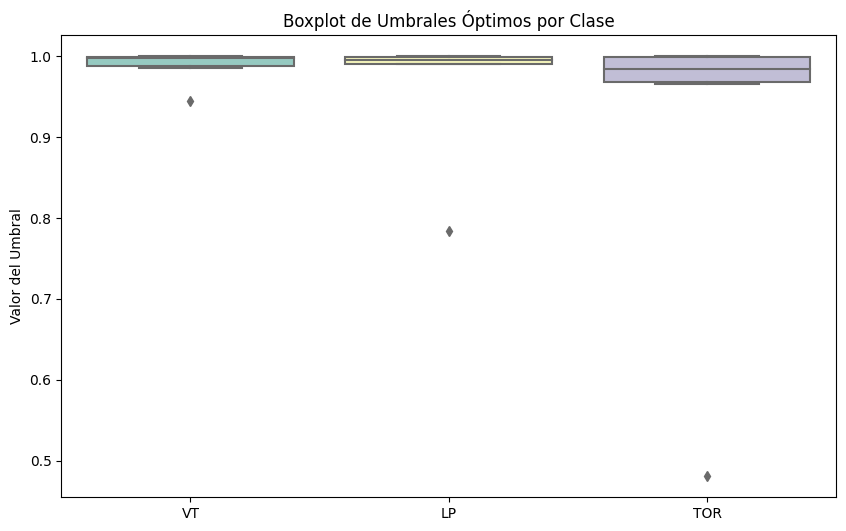

In [17]:
# Crear un DataFrame de pandas para facilitar la visualización

data = pd.DataFrame({'VT': th_0, 'LP': th_1, 'TOR': th_2})

# Crear el gráfico de boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, palette='Set3')
plt.title('Boxplot de Umbrales Óptimos por Clase')
plt.ylabel('Valor del Umbral')
plt.show()

Resumen gráfico para obtener uma vista global del valor de los umbrales durante los 6 folds.

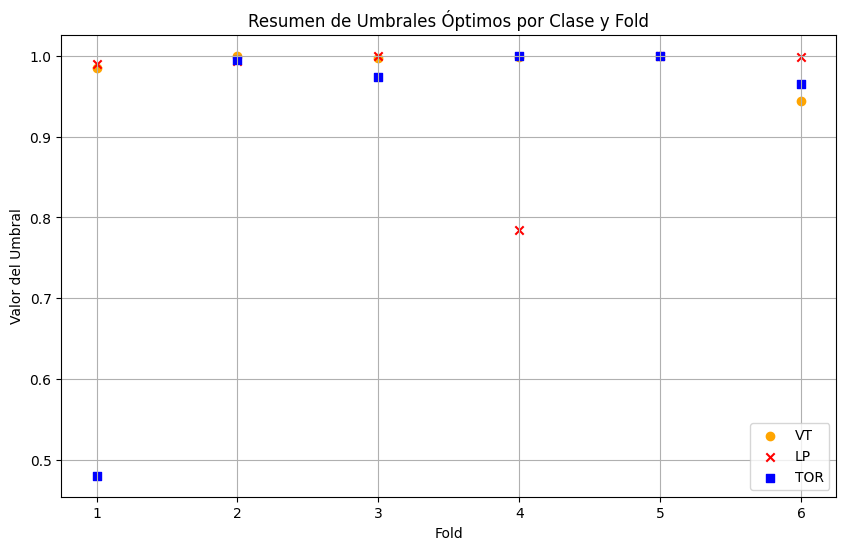

In [18]:
# Crear una figura para el resumen gráfico
plt.figure(figsize=(10, 6))

# Crear un gráfico de dispersión para cada clase
plt.scatter(range(1, 7), th_0, marker='o', label='VT', color='orange')
plt.scatter(range(1, 7), th_1, marker='x', label='LP', color='red')
plt.scatter(range(1, 7), th_2, marker='s', label='TOR', color='blue')

# Configuración del gráfico
plt.title('Resumen de Umbrales Óptimos por Clase y Fold')
plt.xlabel('Fold')
plt.ylabel('Valor del Umbral')
plt.xticks(range(1, 7))
plt.legend(loc='lower right')
plt.grid(True)

# Mostrar el gráfico
plt.show()

El valor de umbral TOR indica que el modelo está siendo muy permisivo en términos de lo que considera una predicción TOR positiva, y a medida que avanza el proceso, se vuelve más conservador y requiere un mayor nivel de confianza para hacer una predicción positiva. el modelo está dispuesto a tomar más riesgos al clasificar instancias como positivas, pero a medida que el proceso avanza, se vuelve más cauteloso y conservador. Esto podría deberse a que el modelo inicialmente necesita ajustarse a los datos y, con el tiempo, se vuelve más preciso y selectivo en sus predicciones (Esto también sucede con la clases LP).                                  
En el caso del umbral VT el modelo comienza siendo muy conservador al clasificar instancias como negativas, lo que resulta en una alta tasa de falsos negativos. A medida que avanza el proceso, el modelo se vuelve más permisivo y comienza a clasificar más instancias como positivas, lo que disminuye la tasa de falsos negativos a expensas de un posible aumento en los falsos positivos. La tendencia de inicio conservador y luego volverse más permisivo puede indicar que el modelo inicialmente tenía una alta incertidumbre o requería una mayor confianza para realizar una predicción positiva. Con el tiempo, a medida que el modelo se ajusta a los datos o se entrena más, puede ganar confianza y disminuir el umbral para permitir más predicciones positivas.

**Matriz de Confusión**

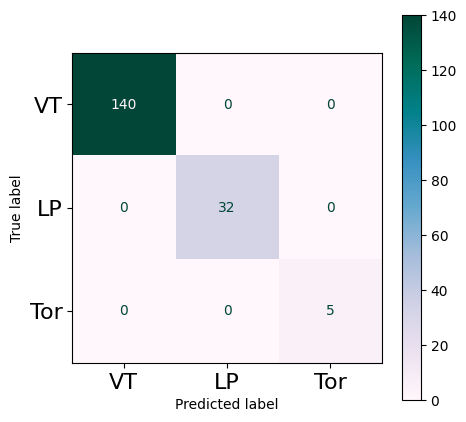

[[[ 37   0]
  [  0 140]]

 [[145   0]
  [  0  32]]

 [[172   0]
  [  0   5]]]
matriz VT  [[ 37   0]
 [  0 140]]
matriz LP  [[145   0]
 [  0  32]]
matriz Tor  [[172   0]
 [  0   5]]


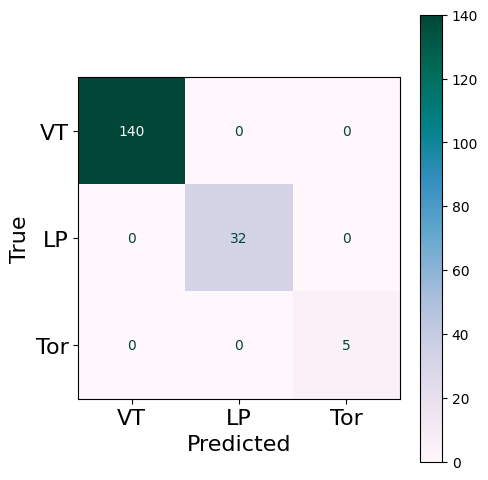

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

y_pred_ = np.rint(y_pred)
y_salida = []
for i in range(len(y_pred)):
  if y_pred_[i,0] > 0:
    y_salida.append('VT')
  if y_pred_[i,1] > 0:
    y_salida.append('LP')
  if y_pred_[i,2] > 0:
    y_salida.append('Tor')


y_true = []
for i in range(len(y_test)):
  if y_test[i,0] > 0:
    y_true.append('VT')
  if y_test[i,1] > 0:
    y_true.append('LP')
  if y_test[i,2] > 0:
    y_true.append('Tor')

c = confusion_matrix (y_true , y_salida , labels = ["VT", "LP", "Tor"] , sample_weight = None)
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=["VT", "LP", "Tor"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('True', fontsize=16)
# ax.set_title('Confusion Matrix', fontsize=18)
plt.tight_layout()
plt.savefig('confusion_matrix.pdf', dpi=400, format='pdf')

plt.rcParams.update({'font.size': 16})

cm = multilabel_confusion_matrix(y_true, y_salida, labels=["VT", "LP", "Tor"])
print(cm)
cmVT = cm[0]
cmLP = cm[1]
cmTor = cm[2]
print('matriz VT ', cmVT)
print('matriz LP ', cmLP)
print('matriz Tor ', cmTor)

# **Evaluación con Métricas de Desempeño**

In [20]:
def calcular_sensitividad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FN = CM[1,0]
  sen = 100*(TP/(TP+FN))
  print('Sensitividad ' + clase_sismo + ': {:.1f}%'.format(sen))
  return sen


def calcular_especificidad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TN = CM[0,0]
  FP = CM[0,1]
  esp = 100*(TN/(TN+FP))
  print('Especificidad ' + clase_sismo + ': {:.1f}%'.format(esp))
  return esp


def calcular_precision(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FP = CM[0,1]
  pres = 100*(TP/(TP+FP))
  print('Precisión ' + clase_sismo + ': {:.1f}%'.format(pres))
  return pres


def calcular_f1(sencitividad, precision, clase_sismo):
  f1 = 2*(precision*sencitividad)/(precision+sencitividad)
  print('f1 score ' + clase_sismo + ': {:.1f}%'.format(f1))
  return f1

In [21]:
# Calculo de Especificidad
esp_1 = calcular_especificidad('VT')
esp_2 = calcular_especificidad('LP')
esp_3 = calcular_especificidad('Tor')
# Cálculo de Sensitividad
sen_1 = calcular_sensitividad('VT')
sen_2 = calcular_sensitividad('LP')
sen_3 = calcular_sensitividad('Tor')
# Cálculo de Precisión
pres_1 = calcular_precision('VT')
pres_2 = calcular_precision('LP')
pres_3 = calcular_precision('Tor')
# Cálculo de f1 score
f1_1 = calcular_f1(sen_1,pres_1,'VT')
f1_2 = calcular_f1(sen_2,pres_2,'LP')
f1_3 = calcular_f1(sen_3,pres_3,'Tor')

Especificidad VT: 100.0%
Especificidad LP: 100.0%
Especificidad Tor: 100.0%
Sensitividad VT: 100.0%
Sensitividad LP: 100.0%
Sensitividad Tor: 100.0%
Precisión VT: 100.0%
Precisión LP: 100.0%
Precisión Tor: 100.0%
f1 score VT: 100.0%
f1 score LP: 100.0%
f1 score Tor: 100.0%


In [22]:
from sklearn.metrics import classification_report
# y_pred_label, y_test_label
target_names = ['VT', 'LP', 'Tor']
print(classification_report(y_test, y_pred_, target_names=target_names))

              precision    recall  f1-score   support

          VT       1.00      1.00      1.00       140
          LP       1.00      1.00      1.00        32
         Tor       1.00      1.00      1.00         5

   micro avg       1.00      1.00      1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177
 samples avg       1.00      1.00      1.00       177



# **VALIDACIÓN      DEL     MODELO**

Concatenamos val_1, val_2 y val_3 que forman el 20% del total de los datos que se reservó para la validación y se aplica *shufle*. Luego se obtiene el vector etiquetas.

In [23]:
X_val = np.concatenate([val_s1,val_s2, val_s3], axis=0)

Al graficar las señales para comparar con algunas señales de entrenamiento, puede verse un retraso en las señales de validación, esto se debe a que las señales de entrenamiento que estoy usando tienen una columna adicional donde se indica la clase

Text(0.5, 0, 'Components number')

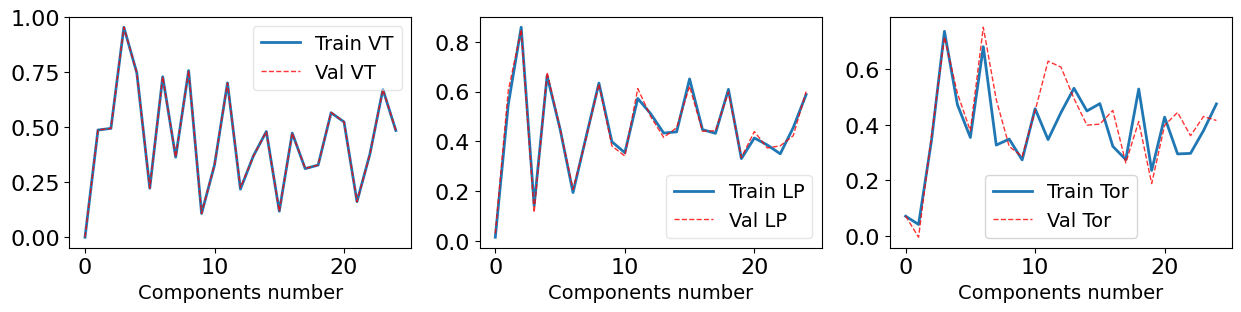

In [28]:
# Graficando
plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.plot(D_train_s1[236, 1:], lw=2, label="Train VT")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.subplot(132)
plt.plot(D_train_s2[46, 1:], lw=2, label="Train LP")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.subplot(133)
plt.plot(D_train_s3[23, 1:], lw=2, label="Train Tor")
plt.legend(fontsize='14')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)



plt.subplot(131)
plt.plot(val_s1[44], 'r--', alpha=0.8, lw=1, label="Val VT")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xlabel('Components number', fontsize='14')
plt.subplot(132)
plt.plot(val_s2[34], 'r--', alpha=0.8, lw=1, label="Val LP")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xlabel('Components number', fontsize='14')
plt.subplot(133)
plt.plot(val_s3[4], 'r--', alpha=0.8, lw=1, label="Val Tor")
plt.legend(fontsize='14')
plt.xlabel('Components number', fontsize='14')


Generando vector de etiquetas

In [29]:
# Crear el vector de etiquetas
class_VT = np.zeros(val_s1.shape[0])
class_LP = np.ones(val_s2.shape[0])
class_TOR = 2 * np.ones(val_s3.shape[0])

# Concatenar los vectores de etiquetas
labels = np.concatenate((class_VT, class_LP, class_TOR))

labels = labels[:, np.newaxis]
X_val = np.concatenate((labels, X_val), axis=1)
print(X_val.shape)

np.random.shuffle(X_val)

# Vector con etiquetas para validación
y_val = X_val[:, 0]

# Eliminando la primera columna de las señales, donde estaba el vector etiquetas
X_val = X_val[:, 1:]
print(X_val.shape, y_val.shape)
# print(y_val)  # para verificar

(443, 26)
(443, 25) (443,)


Aplicamos *shuffle* y extraemos el vector de rotulos

In [30]:
class_final = clasificador.predict(X_val)

14/14 [==============================] - 0s 2ms/step


Evaluación del modelo

**Sensibilidad (Recall):**
La sensibilidad mide la proporción de casos positivos reales que se clasificaron correctamente como positivos.

Otorgando pesos a la clase minoritaria

In [31]:
from sklearn.utils.class_weight import compute_class_weight

# Calcula los pesos de clase basados en la distribución de clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_val), y=y_val)

# Convierte los pesos en un diccionario para su uso en Scikit-learn
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Imprime los pesos de clase
print("Pesos de clase:", class_weight_dict)

Pesos de clase: {0: 0.42432950191570884, 1: 1.823045267489712, 2: 10.547619047619047}


In [32]:
# Calcula la clase predicha para cada muestra
clase_predicha = np.argmax(class_final, axis=1)
# Reemplaza los 1 por 0 y los 2 por 1
clase_predicha = np.where(clase_predicha == 1, 0, np.where(clase_predicha == 2, 1, clase_predicha))
# clase_predicha ahora contendrá la clase predicha para cada muestra
#print(clase_predicha)

In [33]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

num_class = 3
y_final = clase_predicha

# Convertir y_val & y_final a una lista de enteros
y_val = [int(label) for label in y_val]
y_final = [int(label) for label in y_final]

# Cálculo de las Matrices de Confusión para cada clase
matrices = [confusion_matrix([y_true], [y_pred]) for y_true, y_pred in zip(y_val, y_final)]
total_TN = sum(cm.diagonal()[:-1].sum() for cm in matrices)  # Suma de todos los verdaderos negativos
total_FP = sum(cm[-1, :-1].sum() for cm in matrices)        # Suma de todos los falsos positivos
# Cálculo especificidad por cada clase
specif_per_class = []
for cm in matrices:
  TN = cm.diagonal()[:-1].sum()   # Suma de los TN de todas clases, menos la última
  FP = cm[-1, :-1].sum()    # Suma de FP de la última clase
  specif = 0 if (TN + FP) == 0 else TN / (TN + FP)
  specif_per_class.append(specif)

# Cálculo de métricas 'PONDERADAS' a la clase mayoritaria
recall_pond = recall_score(y_val, y_final, average='weighted')
f1_pond = f1_score(y_val, y_final, average='weighted')
esp_pond = sum(specif_per_class[i] * class_weights[i] for i in range(num_class)) / sum(class_weights)
g_mean_pond = (recall_pond * esp_pond) ** 0.5
auc_pond = roc_auc_score(y_val, class_final, average='weighted', multi_class='ovr')

# Cálculo de métricas 'MACRO' donde cada clase tiene igual importancia
recall_macro = recall_score(y_val, y_final, average='macro')
f1_macro = f1_score(y_val, y_final, average='macro')
esp_macro = sum(specif_per_class) / num_class
g_mean_macro = (recall_macro * esp_macro) ** 0.5
auc_macro = roc_auc_score(y_val, class_final, average='macro', multi_class='ovr')

# Cálculo de métricas 'MICRO' para una visión global del rendimiento del modelo
recall_micro = recall_score(y_val, y_final, average='micro')
f1_micro = f1_score(y_val, y_final, average='micro')
esp_micro = total_TN / (total_TN + total_FP)
g_mean_micro = (recall_micro * esp_micro) ** 0.5
auc_micro = roc_auc_score(y_val, class_final, average='micro', multi_class='ovr')

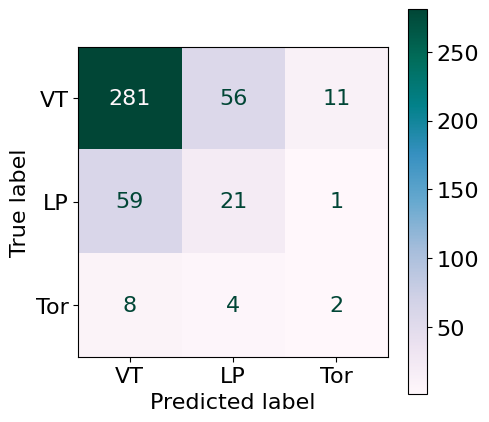

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define tus etiquetas legibles
etiquetas = ["VT", "LP", "Tor"]

# Convierte y_val a etiquetas legibles
y_true = np.array(etiquetas)[y_val]

# Convierte las predicciones en etiquetas legibles
y_salida = np.array(etiquetas)[np.argmax(class_final, axis=1)]

# Calcula la matriz de confusión
c = confusion_matrix(y_true, y_salida, labels=etiquetas)

# Muestra la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=etiquetas)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='PuBuGn', colorbar=True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


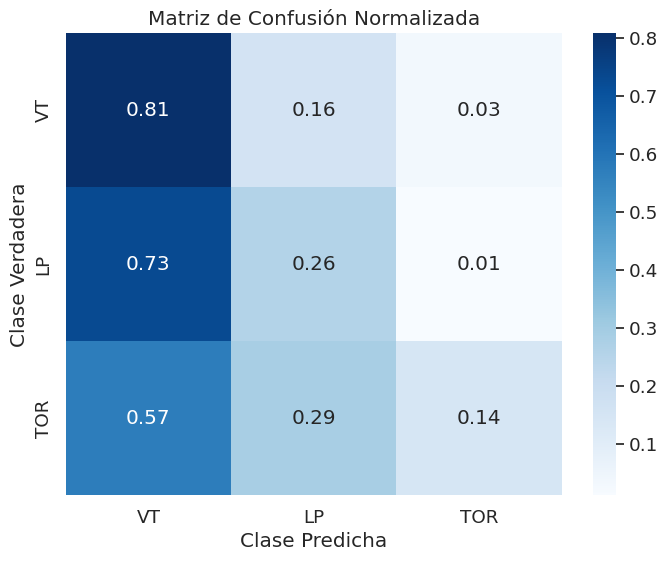

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Supongamos que tienes tu matriz de confusión en 'confusion_matrix'
# Debes reemplazar esto con tus propios valores

# Calcula la matriz de confusión normalizada
row_sums = c.sum(axis=1, keepdims=True)
normalized_c = c / row_sums

# Define las etiquetas de las clases
labels = ["VT", "LP", "TOR"]

# Crea un mapa de calor (heatmap) con seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta el tamaño de la fuente
sns.heatmap(normalized_c, annot=True, fmt=".2f",
            cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión Normalizada')
plt.show()

In [36]:
metrics_dict = {
    'Metrica': ['Recall Ponderado', 'F1 Ponderado', 'Especificidad Ponderada', 'G-Mean Ponderado', 'AUC Ponderado',
                'Recall Macro', 'F1 Macro', 'Especificidad Macro', 'G-Mean Macro', 'AUC Macro',
                'Recall Micro', 'F1 Micro', 'Especificidad Micro', 'G-Mean Micro', 'AUC Micro'],
    'Valor': [recall_pond, f1_pond, esp_pond, g_mean_pond, auc_pond,
              recall_macro, f1_macro, esp_macro, g_mean_macro, auc_macro,
              recall_micro, f1_micro, esp_micro, g_mean_micro, auc_micro]
}
metrics_df = pd.DataFrame(metrics_dict)
print(metrics_df)

                    Metrica     Valor
0          Recall Ponderado  0.762980
1              F1 Ponderado  0.685269
2   Especificidad Ponderada  0.000000
3          G-Mean Ponderado  0.000000
4             AUC Ponderado  0.555810
5              Recall Macro  0.326912
6                  F1 Macro  0.296164
7       Especificidad Macro  0.000000
8              G-Mean Macro  0.000000
9                 AUC Macro  0.588454
10             Recall Micro  0.762980
11                 F1 Micro  0.762980
12      Especificidad Micro  0.000000
13             G-Mean Micro  0.000000
14                AUC Micro  0.762046


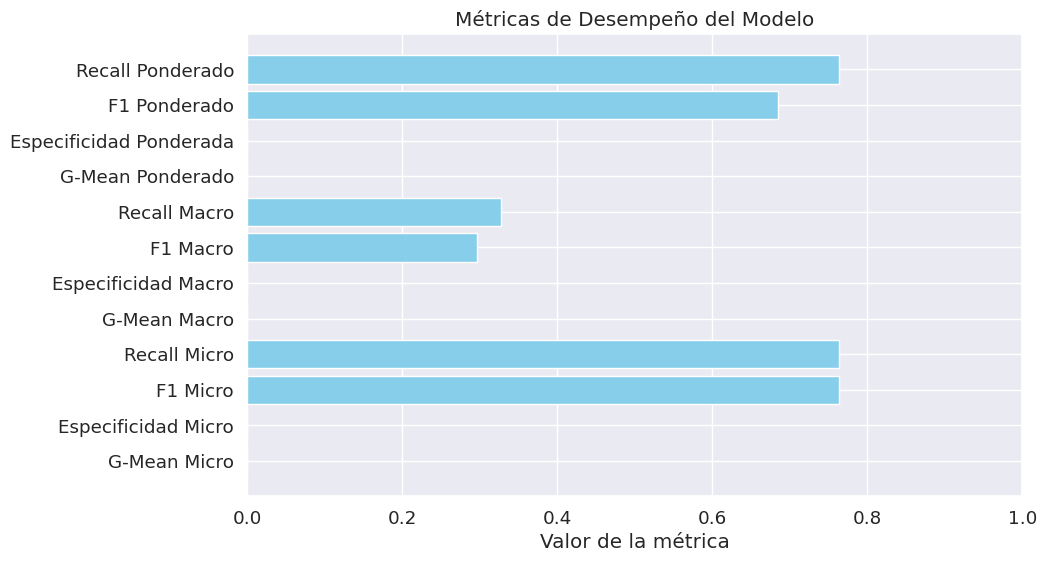

In [37]:
import matplotlib.pyplot as plt

# Define las métricas y sus valores
metricas = ['Recall Ponderado', 'F1 Ponderado', 'Especificidad Ponderada', 'G-Mean Ponderado',
            'Recall Macro', 'F1 Macro', 'Especificidad Macro', 'G-Mean Macro',
            'Recall Micro', 'F1 Micro', 'Especificidad Micro', 'G-Mean Micro']

valores = [recall_pond, f1_pond, esp_pond, g_mean_pond,
           recall_macro, f1_macro, esp_macro, g_mean_macro,
           recall_micro, f1_micro, esp_micro, g_mean_micro]

# Crea un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(metricas, valores, color='skyblue')
plt.xlabel('Valor de la métrica')
plt.title('Métricas de Desempeño del Modelo')
plt.xlim(0, 1)  # Ajusta el rango del eje x si es necesario
plt.gca().invert_yaxis()  # Invierte el eje y para que las métricas más altas estén arriba
plt.show()

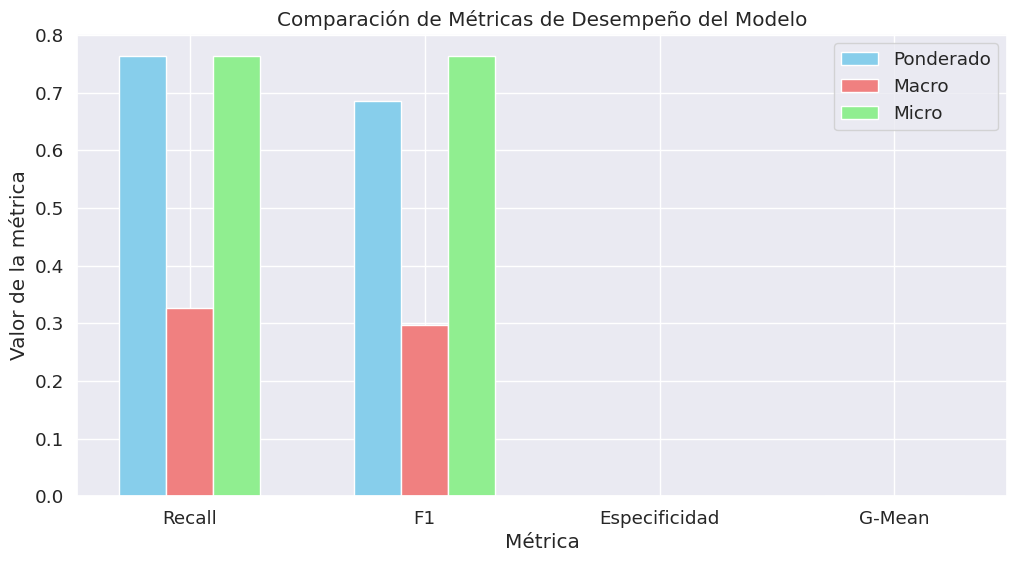

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Define las métricas y sus valores
metricas = ['Recall', 'F1', 'Especificidad', 'G-Mean']
etiquetas = ['Ponderado', 'Macro', 'Micro']

# Valores de las métricas para las tres etiquetas
valores = np.array([[recall_pond, f1_pond, esp_pond, g_mean_pond],
                   [recall_macro, f1_macro, esp_macro, g_mean_macro],
                   [recall_micro, f1_micro, esp_micro, g_mean_micro]])

colores = ['skyblue', 'lightcoral', 'lightgreen']

# Crea un gráfico de barras superpuestas
plt.figure(figsize=(12, 6))

# Ancho de cada barra
bar_width = 0.2
index = np.arange(len(metricas))

for i in range(len(etiquetas)):
    plt.bar(index + i * bar_width, valores[i], bar_width, label=etiquetas[i], color=colores[i])

plt.xlabel('Métrica')
plt.ylabel('Valor de la métrica')
plt.title('Comparación de Métricas de Desempeño del Modelo')
plt.xticks(index + bar_width, metricas)
plt.legend()
plt.show()


Cálculo de Métricas ponderadas por clase

In [39]:
from sklearn.preprocessing import LabelBinarizer

# Crea un objeto LabelBinarizer
lb = LabelBinarizer()

# Convierte las etiquetas de clases en una matriz binaria
y_salida_bin = lb.fit_transform(y_salida)

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Número de clases
num_classes = y_val_bin.shape[1]

# Crea un diccionario para almacenar las métricas por clase
class_metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC AUC': [],
}

for class_idx in range(num_classes):
    y_true_class = y_val_bin[:, class_idx]
    y_pred_class = y_salida_bin[:, class_idx]

    # Calcula las métricas para la clase actual
    accuracy = accuracy_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class)
    recall = recall_score(y_true_class, y_pred_class)
    f1 = f1_score(y_true_class, y_pred_class)
    roc_auc = roc_auc_score(y_true_class, y_pred_class)

    # Almacena las métricas en el diccionario
    class_metrics['Accuracy'].append(accuracy)
    class_metrics['Precision'].append(precision)
    class_metrics['Recall'].append(recall)
    class_metrics['F1-Score'].append(f1)
    class_metrics['ROC AUC'].append(roc_auc)


In [54]:
df = pd.DataFrame(class_metrics, index=[f'Clase {i}' for i in range(1, num_classes + 1)])  # Personaliza los índices según tus clases

# Muestra el DataFrame como una tabla
print(df)

         Accuracy  Precision    Recall  F1-Score   ROC AUC
Clase 1  0.284424   0.691358  0.160920  0.261072  0.448881
Clase 2  0.790068   0.071429  0.012346  0.021053  0.488217
Clase 3  0.218962   0.022989  0.571429  0.044199  0.389444


CURVAS ROC

Convertimos el vector con las etiquetas verdaderas para un código one-hot.

In [55]:
from sklearn.preprocessing import label_binarize

# Codificar las etiquetas verdaderas en un formato binario (one-hot encoding)
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])  # Ajusta las clases según tu etiquetado

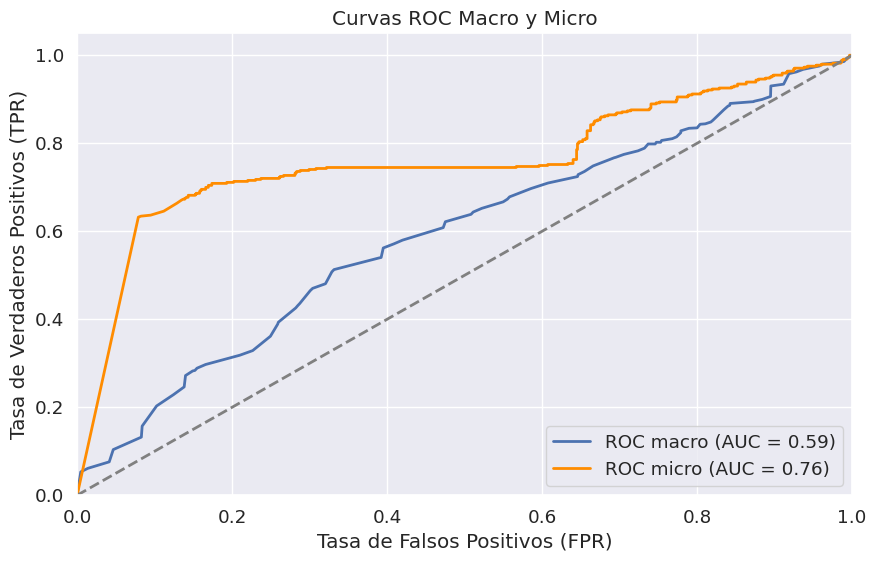

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcula las curvas ROC y los valores AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(etiquetas)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], class_final[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcula la curva ROC macro promediando los valores de todas las clases
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(etiquetas))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(etiquetas)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(etiquetas)
roc_auc_macro = auc(all_fpr, mean_tpr)

# Calcula la curva ROC micro agregando todas las predicciones y etiquetas verdaderas
all_y_true = y_val_bin.ravel()
all_y_scores = class_final.ravel()
fpr_micro, tpr_micro, _ = roc_curve(all_y_true, all_y_scores)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Crea la gráfica de las curvas ROC
plt.figure(figsize=(10, 6))

# Curva ROC macro
plt.plot(all_fpr, mean_tpr, color='b', linestyle='-', lw=2, label='ROC macro (AUC = {:.2f})'.format(roc_auc_macro))

# Curva ROC micro
plt.plot(fpr_micro, tpr_micro, color='darkorange', linestyle='-', lw=2, label='ROC micro (AUC = {:.2f})'.format(roc_auc_micro))

# Línea de referencia (clasificación aleatoria)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Configuración de la gráfica
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Macro y Micro')
plt.legend(loc='lower right')
plt.grid(True)

# Muestra la gráfica
plt.show()

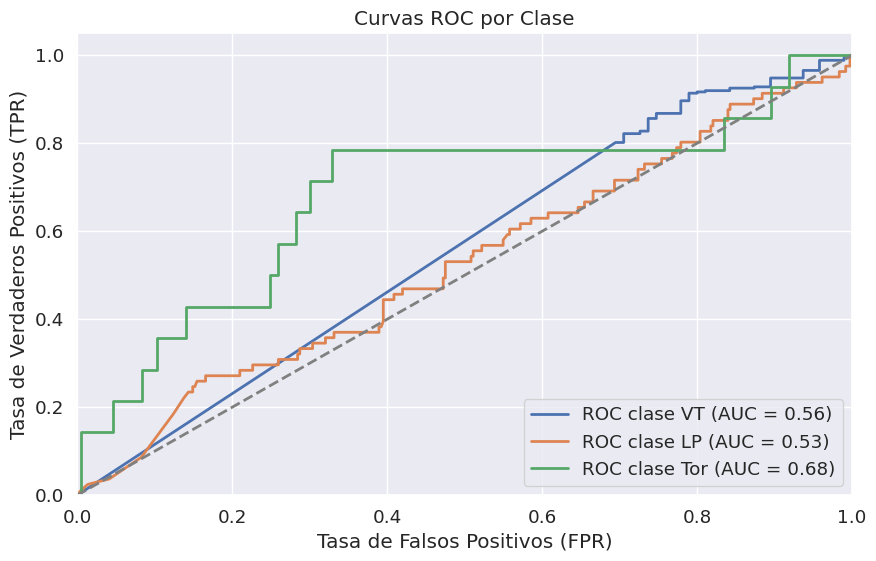

In [57]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Define las etiquetas de las clases
etiquetas = ["VT", "LP", "Tor"]

# Calcula las curvas ROC y los valores AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(etiquetas)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], class_final[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Crea la gráfica de las curvas ROC en un solo gráfico
plt.figure(figsize=(10, 6))

# Trazar las curvas ROC para cada clase
for i in range(len(etiquetas)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC clase {} (AUC = {:.2f})'.format(etiquetas[i], roc_auc[i]))

# Línea de referencia (clasificación aleatoria)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Configuración de la gráfica
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.grid(True)

# Muestra la gráfica
plt.show()

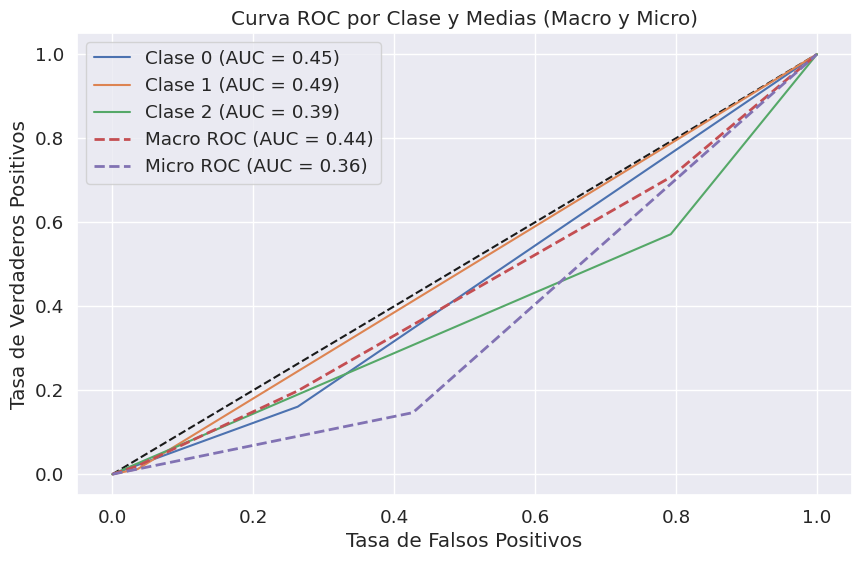

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import numpy as np
import matplotlib.pyplot as plt

# Calcula las curvas ROC y los valores AUC por clase
fpr_class = {}
tpr_class = {}
roc_auc_class = {}
n_classes = num_classes  # Número de clases

for class_idx in range(n_classes):
    fpr_class[class_idx], tpr_class[class_idx], _ = roc_curve(y_val_bin[:, class_idx], y_salida_bin[:, class_idx])
    roc_auc_class[class_idx] = auc(fpr_class[class_idx], tpr_class[class_idx])

# Calcula la curva ROC macro
all_fpr = np.unique(np.concatenate([fpr_class[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_class[i], tpr_class[i])
mean_tpr /= n_classes
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Calcula la curva ROC micro
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_salida_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Gráfico de las curvas ROC por clase
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(n_classes):
    plt.plot(fpr_class[i], tpr_class[i], label=f'Clase {i} (AUC = {roc_auc_class[i]:.2f})')

# Curva ROC macro
plt.plot(fpr_macro, tpr_macro, label=f'Macro ROC (AUC = {roc_auc_macro:.2f})', linestyle='--', linewidth=2)

# Curva ROC micro
plt.plot(fpr_micro, tpr_micro, label=f'Micro ROC (AUC = {roc_auc_micro:.2f})', linestyle='--', linewidth=2)

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC por Clase y Medias (Macro y Micro)')
plt.legend(loc='best')
plt.show()

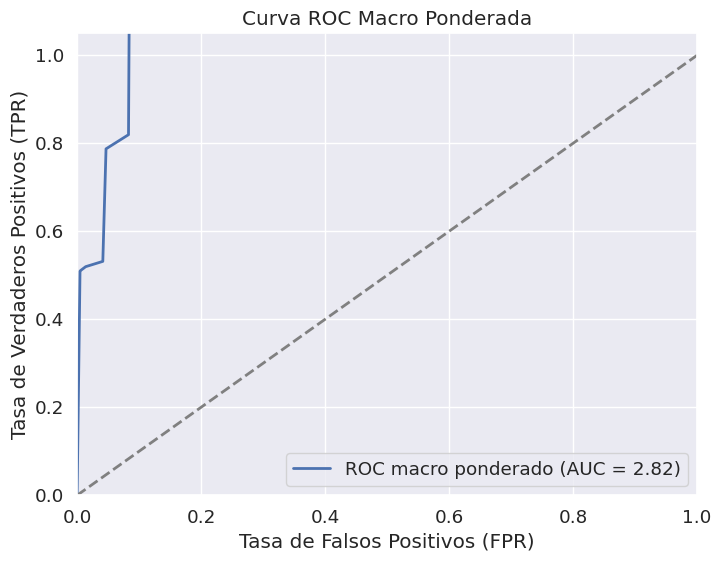

In [59]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define las etiquetas de las clases
etiquetas = ["VT", "LP", "Tor"]

# Calcula las curvas ROC y los valores AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(etiquetas)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], class_final[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcula la curva ROC macro ponderada promediando los valores de todas las clases
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(etiquetas))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(etiquetas)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) * class_weight_dict[i]   # Aplicar pesos
mean_tpr /= len(etiquetas)
roc_auc_macro_ponderado = auc(all_fpr, mean_tpr)

# Crea la gráfica de la curva ROC macro ponderada
plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr, color='b', linestyle='-', lw=2,
         label='ROC macro ponderado (AUC = {:.2f})'.format(roc_auc_macro_ponderado))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Macro Ponderada')
plt.legend(loc='lower right')
plt.grid(True)

# Muestra la gráfica
plt.show()

Curva Precision - Recall

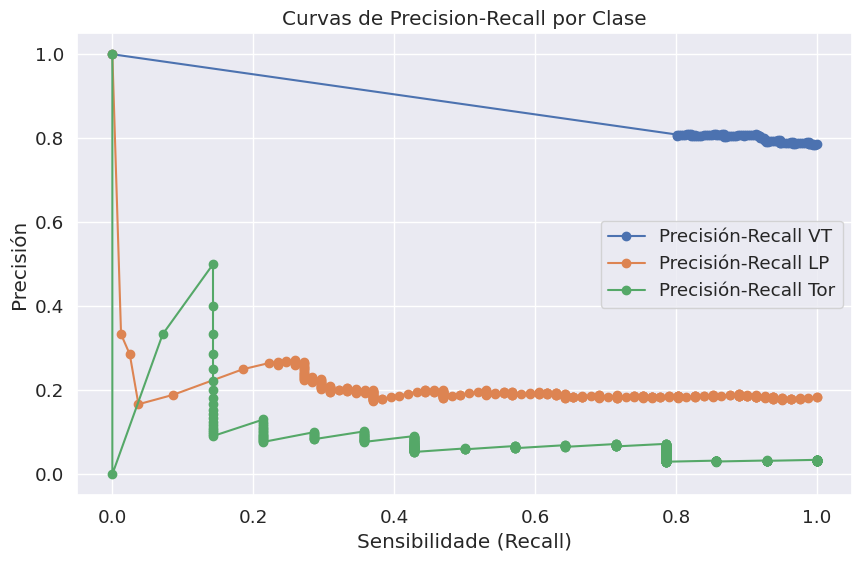

In [45]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Supongamos que tienes tus etiquetas verdaderas y las probabilidades de las predicciones
y_true = np.array(y_val)  # Convierte tus etiquetas verdaderas a un arreglo numpy
y_scores = class_final  # Reemplaza esto con las probabilidades de las predicciones

# Define las etiquetas de las clases
etiquetas = ["VT", "LP", "Tor"]
# Mapeo de etiquetas a valores numéricos
mapeo_etiquetas = {"VT": 0, "LP": 1, "Tor": 2}

# Inicializa un diccionario para almacenar las curvas de precisión-recuperación
precision_dict = {}
recall_dict = {}
thresholds_dict = {}

# Calcula y almacena las curvas de precisión-recuperación para cada clase
for etiqueta in etiquetas:
    y_true_class = (y_true == mapeo_etiquetas[etiqueta]).astype(int)
    y_scores_class = y_scores[:, mapeo_etiquetas[etiqueta]]
    precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
    precision_dict[etiqueta] = precision
    recall_dict[etiqueta] = recall
    thresholds_dict[etiqueta] = thresholds

# Grafica las curvas de precisión-recuperación para cada clase en una sola figura
plt.figure(figsize=(10, 6))
for etiqueta in etiquetas:
    plt.plot(recall_dict[etiqueta], precision_dict[etiqueta], marker='o', linestyle='-', label=f'Precisión-Recall {etiqueta}')

plt.xlabel('Sensibilidade (Recall)')
plt.ylabel('Precisión')
plt.title('Curvas de Precision-Recall por Clase')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Histograma de Probabilidades

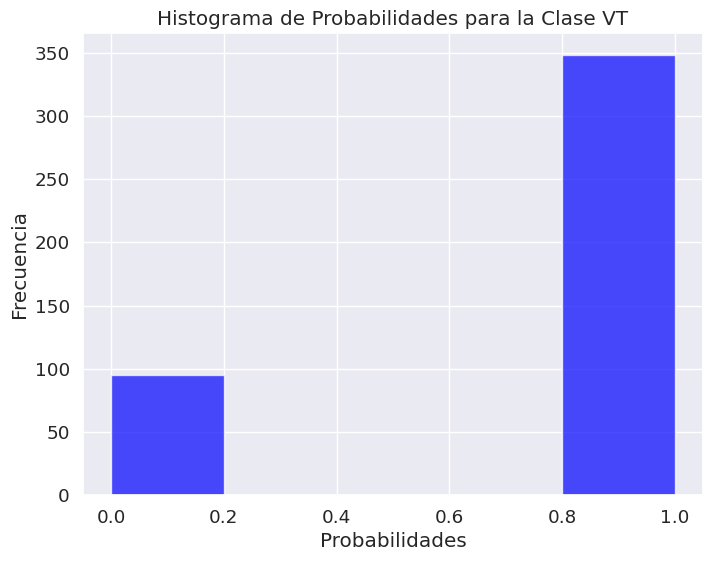

In [46]:
import matplotlib.pyplot as plt

# Clase de interés (cambia a la que necesites)
clase_interes = "VT"

# Obtén las probabilidades de la clase de interés
probabilidades_clase_interes = class_final[:, etiquetas.index(clase_interes)]

# Crea un histograma
plt.figure(figsize=(8, 6))
plt.hist(probabilidades_clase_interes, bins=5, color='blue', alpha=0.7)
plt.title(f'Histograma de Probabilidades para la Clase {clase_interes}')
plt.xlabel('Probabilidades')
plt.ylabel('Frecuencia')
plt.grid(True)

# Muestra el histograma
plt.show()

La columna de la izquierda indica que hubo 100 ejemplos VT donde el modelo predijo bajas probabilidades para ser esta clase

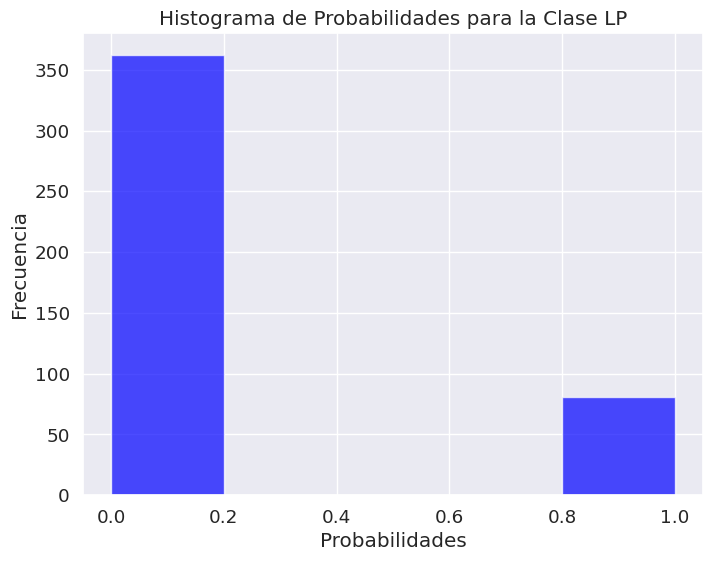

In [47]:
import matplotlib.pyplot as plt

# Clase de interés (cambia a la que necesites)
clase_interes = "LP"

# Obtén las probabilidades de la clase de interés
probabilidades_clase_interes = class_final[:, etiquetas.index(clase_interes)]

# Crea un histograma
plt.figure(figsize=(8, 6))
plt.hist(probabilidades_clase_interes, bins=5, color='blue', alpha=0.7)
plt.title(f'Histograma de Probabilidades para la Clase {clase_interes}')
plt.xlabel('Probabilidades')
plt.ylabel('Frecuencia')
plt.grid(True)

# Muestra el histograma
plt.show()

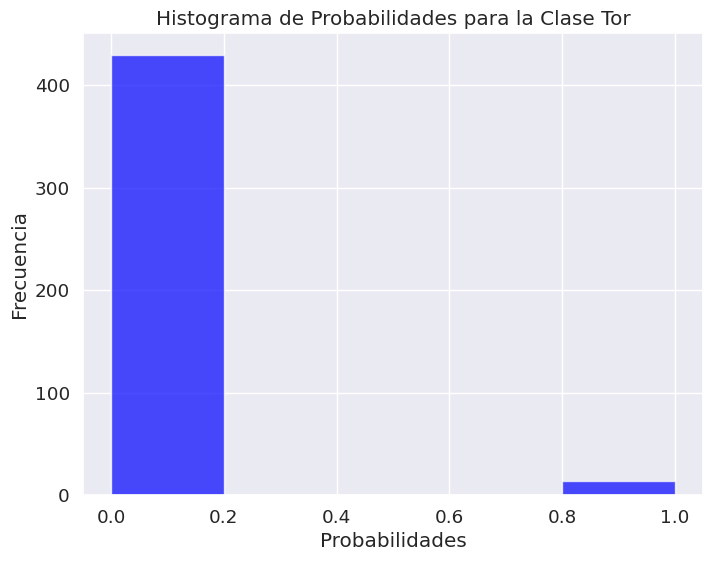

In [48]:
import matplotlib.pyplot as plt

# Clase de interés (cambia a la que necesites)
clase_interes = "Tor"

# Obtén las probabilidades de la clase de interés
probabilidades_clase_interes = class_final[:, etiquetas.index(clase_interes)]

# Crea un histograma
plt.figure(figsize=(8, 6))
plt.hist(probabilidades_clase_interes, bins=5, color='blue', alpha=0.7)
plt.title(f'Histograma de Probabilidades para la Clase {clase_interes}')
plt.xlabel('Probabilidades')
plt.ylabel('Frecuencia')
plt.grid(True)

# Muestra el histograma
plt.show()

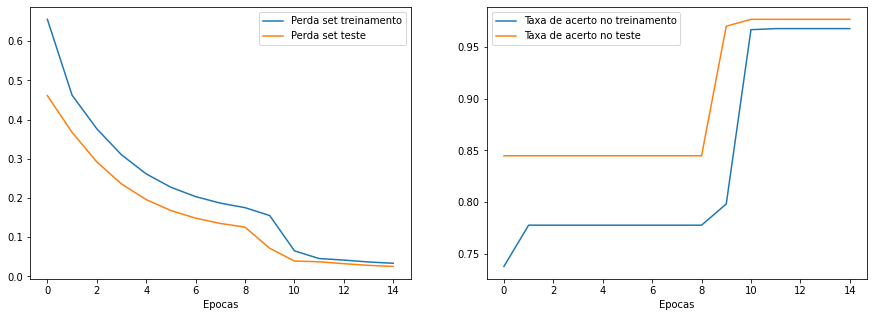

In [ ]:
import matplotlib.pyplot as plt
plt.figure(5, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], label="Perda set treinamento")
plt.plot(historia.history["val_loss"], label="Perda set teste")
plt.xlabel('Epocas')
plt.legend()
plt.subplot(1,2,2)
plt.plot(historia.history["accuracy"], label="Taxa de acerto no treinamento")
plt.plot(historia.history["val_accuracy"], label="Taxa de acerto no teste")
plt.xlabel('Epocas')
plt.legend()

10/10 [==============================] - 0s 3ms/step


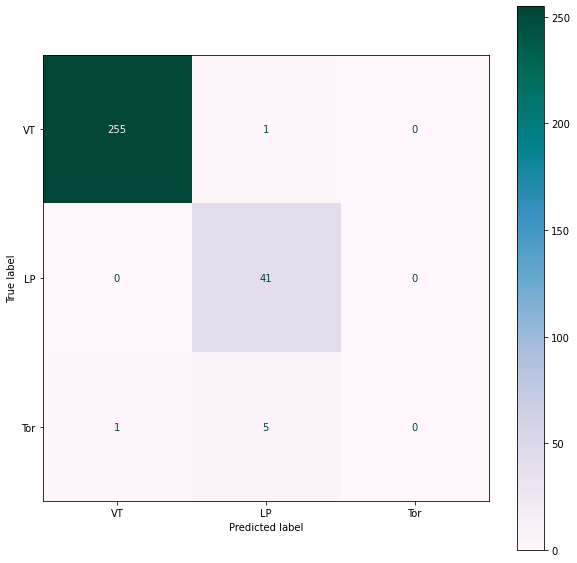

[[[ 46   1]
  [  1 255]]

 [[256   6]
  [  0  41]]

 [[297   0]
  [  6   0]]]
matriz VT  [[ 46   1]
 [  1 255]]
matriz LP  [[256   6]
 [  0  41]]
matriz Tor  [[297   0]
 [  6   0]]


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

clasificador = Model(inputs=entrada, outputs=saida)
y_pred = clasificador.predict(X_test)
y_pred_ = np.rint(y_pred)

y_true = []
for i in range(len(y_test)):
  if y_test[i,0] > 0:
    y_true.append('VT')
  if y_test[i,1] > 0:
    y_true.append('LP')
  if y_test[i,2] > 0:
    y_true.append('Tor')

y_salida = []
for i in range(len(y_pred_)):
  if y_pred_[i,0] > 0:
    y_salida.append('VT')
  if y_pred_[i,1] > 0:
    y_salida.append('LP')
  if y_pred_[i,2] > 0:
    y_salida.append('Tor')

# Matriz de confusión multiclase
c = confusion_matrix ( y_true , y_salida , labels = ["VT", "LP", "Tor"] , sample_weight = None)
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=["VT", "LP", "Tor"])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
plt.show()
plt.show()
cm = multilabel_confusion_matrix(y_true, y_salida, labels=["VT", "LP", "Tor"])
print(cm)
cmVT = cm[0]
cmLP = cm[1]
cmTor = cm[2]
print('matriz VT ', cmVT)
print('matriz LP ', cmLP)
print('matriz Tor ', cmTor)

**Sensitividad y Especificidad**


*   Verdaderos Positivos (TP): La clase de sismo de interés que ha sido clasificada
correctamente,

*   Falsos negativos (FN): La clase de sismo de interés que fue clasificada como otro
tipo de sismo


*   Verdadero negativo (TN): Otros tipo de sismo que fue correctamente clasificado
como un tipo de sismo diferente a la clase de interés, y

*   Falsos positivos (FP): cuando un sismo diferente fue clasificado como si fuera el
simo de la clase de interés.

La **sensitividad** mide la proporción de los sismos de interés detectados
correctamente, una sensitividad del 100% detectará todos los sismos de interés:

$$Sensitividad = \frac{TP}{TP+FN}$$

La **especificidad** mide la proporción de otro tipo de sismos que fueron detectados
correctamente diferentes a la clase de interés. Una especificidad del 100% detectará
sismos diferentes a la clase de interés:

$$Especificidad = \frac{TN}{TN+FP}$$

In [ ]:
def calcular_sensitividad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FN = CM[1,0]
  sen = 100*(TP/(TP+FN))
  print('Sensitividad ' + clase_sismo + ': {:.1f}%'.format(sen))
  return sen


def calcular_especificidad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TN = CM[0,0]
  FP = CM[0,1]
  esp = 100*(TN/(TN+FP))
  print('Especificidad ' + clase_sismo + ': {:.1f}%'.format(esp))
  return esp


def calcular_precision(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FP = CM[0,1]
  pres = 100*(TP/(TP+FP))
  print('Precisión ' + clase_sismo + ': {:.1f}%'.format(pres))
  return pres


def calcular_f1(sencitividad, precision, clase_sismo):
  f1 = 2*(precision*sencitividad)/(precision+sencitividad)
  print('f1 score ' + clase_sismo + ': {:.1f}%'.format(f1))
  return f1

In [ ]:
# Calculo de Especificidad
esp_1 = calcular_especificidad('VT')
esp_2 = calcular_especificidad('LP')
esp_3 = calcular_especificidad('Tor')
# Cálculo de Sensitividad
sen_1 = calcular_sensitividad('VT')
sen_2 = calcular_sensitividad('LP')
sen_3 = calcular_sensitividad('Tor')
# Cálculo de Precisión
pres_1 = calcular_precision('VT')
pres_2 = calcular_precision('LP')
pres_3 = calcular_precision('Tor')
# Cálculo de f1 score
f1_1 = calcular_f1(sen_1,pres_1,'VT')
f1_2 = calcular_f1(sen_2,pres_2,'LP')
f1_3 = calcular_f1(sen_3,pres_3,'Tor')

Especificidad VT: 97.9%
Especificidad LP: 97.7%
Especificidad Tor: 100.0%
Sensitividad VT: 99.6%
Sensitividad LP: 100.0%
Sensitividad Tor: 0.0%
Precisión VT: 99.6%
Precisión LP: 87.2%
Precisión Tor: nan%
f1 score VT: 99.6%
f1 score LP: 93.2%
f1 score Tor: nan%


<ipython-input-48-d14efc6aa696>:38: RuntimeWarning: invalid value encountered in long_scalars
  pres = 100*(TP/(TP+FP))


In [ ]:
from sklearn.metrics import classification_report
# y_pred_label, y_test_label
target_names = ['VT', 'LP', 'Tor']
print(classification_report(y_test, y_pred_, target_names=target_names))

              precision    recall  f1-score   support

          VT       1.00      1.00      1.00       256
          LP       0.87      1.00      0.93        41
         Tor       0.00      0.00      0.00         6

   micro avg       0.98      0.98      0.98       303
   macro avg       0.62      0.67      0.64       303
weighted avg       0.96      0.98      0.97       303
 samples avg       0.98      0.98      0.98       303



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3


for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 3

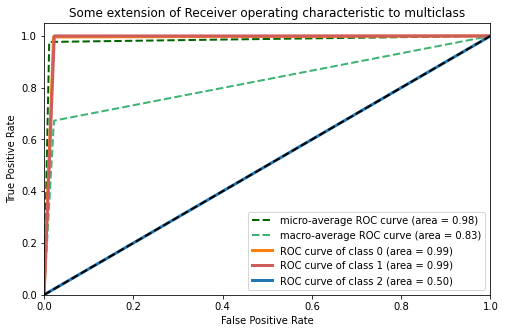

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,5))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="darkgreen", #deeppink
    linestyle="--",
    linewidth=2,
    )

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="mediumseagreen", #
    linestyle="--",
    linewidth=2,
    )

colors = cycle(["tab:orange", "indianred", "tab:blue"])
for i, color in zip(range(n_classes), colors):
  plt.plot(
      fpr[i],
      tpr[i],
      color=color,
      lw=lw,
      label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
   )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()